## Calculating likelihoods for individual channels

In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
from scipy.special import logsumexp
import matplotlib.cm as cm
from pylab import rcParams
import corner


import sys

sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs
from populations.bbh_models import read_hdf5
from sample import sample

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [8]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
channels =['CE']
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            1, 'delta', None)
popsynth_outputs = read_hdf5(file_path, channels[0])

model_names, flow = read_models.get_models(file_path, channels, params, use_flows=True, use_unityweights=True, device='cpu', no_bins=[5])
model_names, KDE = read_models.get_models(file_path, channels, params, use_flows=False, use_unityweights=True, device='cpu')
_, KDE_flowsamps = read_models.get_models('flow_samples.hdf5', channels, params, use_flows=False, use_unityweights=True, device='cpu')

100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


In [9]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [10]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_120123_noweights_5events/flow_models/"
for chnl in channels: flow[chnl].load_model(flow_path, chnl)

## Full likelihood per submodel for all obs

In [7]:
#CE likelihoods
lnlike_flow=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        print((chibid,alphaid))
        lnlike_flow[chibid,alphaid]=sample.lnlike([chibid,alphaid],obsdata, flow, submodels_dict, channels, use_flows=True, prior_pdf=np.array([p_theta[0][0]]))

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)


In [8]:
lnlike_flow

array([[ -59.34111324,  -56.32357024,  -55.55039711,  -56.76097752,
         -63.84022229],
       [ -63.10139075,  -59.71534557,  -58.86266575,  -60.14710756,
         -65.27587659],
       [-105.22833556,  -99.63727951,  -92.81889555,  -90.21436144,
         -80.82352541],
       [-178.08697569, -160.73921575, -140.05857405, -124.56120682,
         -95.42454807]])

In [17]:
#CE posteriors
lnprob_flow=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        print((chibid,alphaid))
        lnprob_flow[chibid,alphaid]=sample.lnpost([chibid,alphaid],obsdata, flow, submodels_dict, channels, _concentration=np.array([1.]), use_flows=True, prior_pdf=np.array([p_theta[0][0]]))

(0, 0)
0.0
-562.3997881941497
(0, 1)
0.0
-590.7138096987925
(0, 2)
0.0
-584.0054571080904
(0, 3)
0.0
-662.4821280325378
(0, 4)
0.0
-663.2819933300551
(1, 0)
0.0
-666.4327431122615
(1, 1)
0.0
-667.0794599712428
(1, 2)
0.0
-665.9806922524863
(1, 3)
0.0
-729.10044527066
(1, 4)
0.0
-701.5249092776974
(2, 0)
0.0
-770.1344897573991
(2, 1)
0.0
-743.0061478552485
(2, 2)
0.0
-717.4775317286112
(2, 3)
0.0
-771.5421568552149
(2, 4)
0.0
-735.6201180664665
(3, 0)
0.0
-1921.311148369711
(3, 1)
0.0
-1416.0201454845776
(3, 2)
0.0
-1203.76133243274
(3, 3)
0.0
-1128.8494622967023
(3, 4)
0.0
-1012.6439945594909


In [18]:
lnprob_flow

array([[ -562.39978819,  -590.7138097 ,  -584.00545711,  -662.48212803,
         -663.28199333],
       [ -666.43274311,  -667.07945997,  -665.98069225,  -729.10044527,
         -701.52490928],
       [ -770.13448976,  -743.00614786,  -717.47753173,  -771.54215686,
         -735.62011807],
       [-1921.31114837, -1416.02014548, -1203.76133243, -1128.8494623 ,
        -1012.64399456]])

In [14]:
#non-CE likelihoods
lnlike_flow=np.zeros((4))
for chibid in range(4):
    print((chibid))
    lnlike_flow[chibid]=sample.lnlike([chibid],obsdata, flow, submodels_dict, channels, use_flows=True, prior_pdf=np.array([p_theta[0][0]]))

0
1
2
3


In [15]:
lnlike_flow

array([-1309.00282145, -1266.08007979, -1298.48497152, -1578.01798248])

Text(0.5, 1.0, 'CE channel likelihoods (flow)')

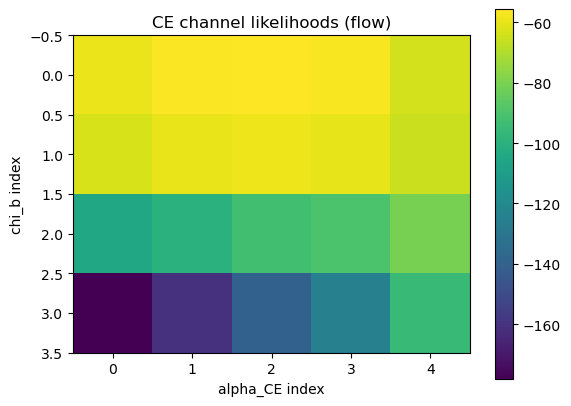

In [9]:
plt.imshow(lnlike_flow)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (flow)')

In [10]:
from functools import reduce
import operator
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

In [11]:
lnlike_kde=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        print((chibid,alphaid))
        lnlike_kde[chibid,alphaid]=sample.lnlike([chibid,alphaid,1.],obsdata, KDE, submodels_dict, ['CE'], use_flows=False, prior_pdf=p_theta)

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)


In [23]:
print(sample.lnpost([chibid,alphaid],obsdata, KDE, submodels_dict, ['CE'],_concentration=np.asarray([1.]), use_flows=False, prior_pdf=p_theta))

0.0
-2472.8295019622333
-2472.8295019622333


## Non-CE KDE likelihoods

In [24]:
lnlike_kde=np.zeros((4))
for chibid in range(4):
    print((chibid))
    lnlike_kde[chibid]=sample.lnlike([chibid],obsdata, KDE, submodels_dict, channels, use_flows=False, prior_pdf=p_theta)

0
1
2
3


In [12]:
lnlike_kde

array([[ -57.11219864,  -66.72987613,  -65.44210271,  -92.22703723,
        -109.94674638],
       [ -57.40306537,  -63.13008395,  -65.69591987,  -90.20378308,
        -104.07456341],
       [ -59.43413551,  -69.68911428,  -64.79070815,  -66.90438275,
         -80.37793645],
       [-198.58226317, -207.61323099, -208.55121307, -201.85040191,
        -223.0584839 ]])

In [276]:
lnlike_flow-lnlike_kde

array([ 111.73795307,  -10.49140814,   13.72207944, 1188.6997653 ])

Text(0.5, 1.0, 'CE channel likelihoods (KDEs)')

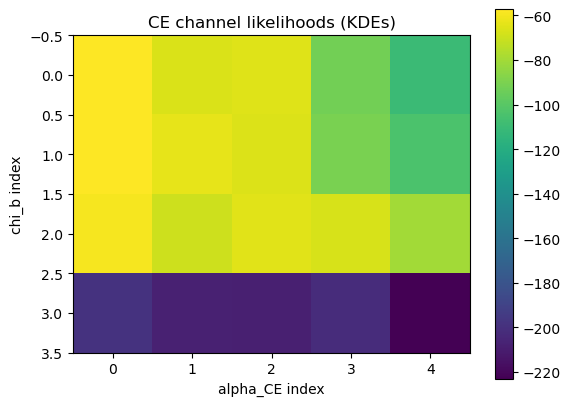

In [13]:
plt.imshow(lnlike_kde)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (KDEs)')

Text(0.5, 1.0, 'CE channel likelihoods ratio flows/kde')

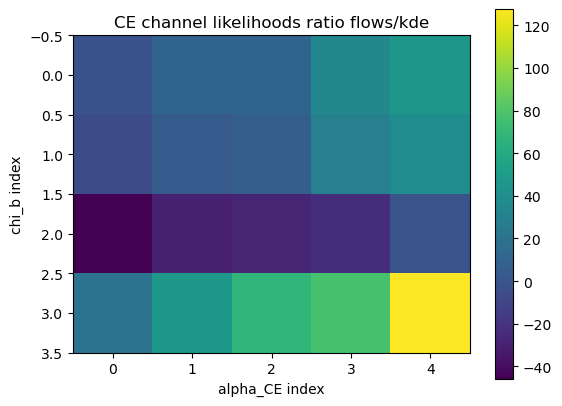

In [14]:
#ratio
plt.imshow(lnlike_flow-lnlike_kde)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods ratio flows/kde')

## Non-CE Likelihood ratio varying with theta space

In [25]:
llh_ratio_kde_flow = np.zeros((4,obsdata.shape[0]))
llh_ratio_kdeflow_flow = np.zeros((4,obsdata.shape[0]))
llh_ratio_kdeflow_kde = np.zeros((4,obsdata.shape[0]))
for chibid in range(4):
    for i,obs in enumerate(obsdata):
        obs = np.reshape(obs, (1,1,4))
        print(obs)
        lnlike_flow_theta=sample.lnlike([chibid],obs, flow, submodels_dict, channels, use_flows=True, prior_pdf=np.array([p_theta[i]]))
        lnlike_kde_theta=sample.lnlike([chibid],obs, KDE, submodels_dict, channels, use_flows=False, prior_pdf=[p_theta[i]])
        lnlike_kdeflow_theta=sample.lnlike([chibid],obs, KDE_flowsamps, submodels_dict, channels, use_flows=False, prior_pdf=[p_theta[i]])
        llh_ratio_kde_flow[chibid,i] = lnlike_flow_theta-lnlike_kde_theta
        llh_ratio_kdeflow_flow[chibid,i] = lnlike_flow_theta-lnlike_kdeflow_theta
        llh_ratio_kdeflow_kde[chibid,i] = lnlike_kde_theta-lnlike_kdeflow_theta

[[[ 2.86412235e+01  8.63770465e-01 -1.49326274e-02  9.15105871e-02]]]
[[[8.86715358 0.56026687 0.18001728 0.09306373]]]
[[[7.93929444 0.69213385 0.03459616 0.06888004]]]
[[[43.53277921  0.61694006  0.32875775  0.49173582]]]
[[[13.25497086  0.27694384  0.24878645  0.15087001]]]
[[[ 2.86412235e+01  8.63770465e-01 -1.49326274e-02  9.15105871e-02]]]
[[[8.86715358 0.56026687 0.18001728 0.09306373]]]
[[[7.93929444 0.69213385 0.03459616 0.06888004]]]
[[[43.53277921  0.61694006  0.32875775  0.49173582]]]
[[[13.25497086  0.27694384  0.24878645  0.15087001]]]
[[[ 2.86412235e+01  8.63770465e-01 -1.49326274e-02  9.15105871e-02]]]
[[[8.86715358 0.56026687 0.18001728 0.09306373]]]
[[[7.93929444 0.69213385 0.03459616 0.06888004]]]
[[[43.53277921  0.61694006  0.32875775  0.49173582]]]
[[[13.25497086  0.27694384  0.24878645  0.15087001]]]
[[[ 2.86412235e+01  8.63770465e-01 -1.49326274e-02  9.15105871e-02]]]
[[[8.86715358 0.56026687 0.18001728 0.09306373]]]
[[[7.93929444 0.69213385 0.03459616 0.06888004

In [199]:
#seeing actual likelihood values at large ratio part of theta space
testobs=np.array([[[30.,0.8,0.0,0.55]]])
print(sample.lnlike([3],testobs, flow, submodels_dict, channels, use_flows=True, prior_pdf=np.array([1.])))
print(sample.lnlike([3],testobs, KDE, submodels_dict, channels, use_flows=False, prior_pdf=[1.]))

likelihood from flow
[[-14.839075]]
likelihood per samp
[[-14.83907509]]
likelihood
[-14.83907509]
lnprob
[-14.83907509]
(lnprob-np.log(alpha)).sum()
-14.839075088500977
-14.839075088500977
likelihood from kde
[-411.48342753]
likelihood per samp
[-411.48342753]
likelihood
[-115.12925465]
lnprob
[-115.12925465]
(lnprob-np.log(alpha)).sum()
-115.12925464970229
-115.12925464970229


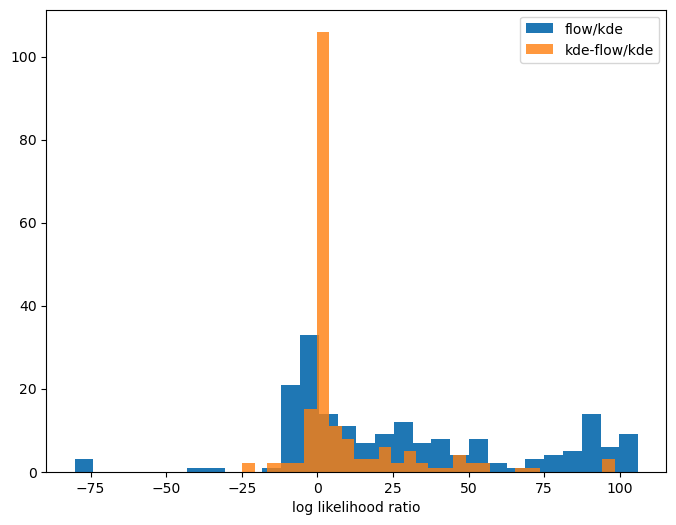

In [17]:
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(np.reshape(llh_ratio_kde_flow,-1), bins=30, label='flow/kde')
plt.hist(np.reshape(-llh_ratio_kdeflow_kde,-1), bins=30, label='kde-flow/kde', alpha=0.8)
plt.xlabel('log likelihood ratio')
plt.legend()

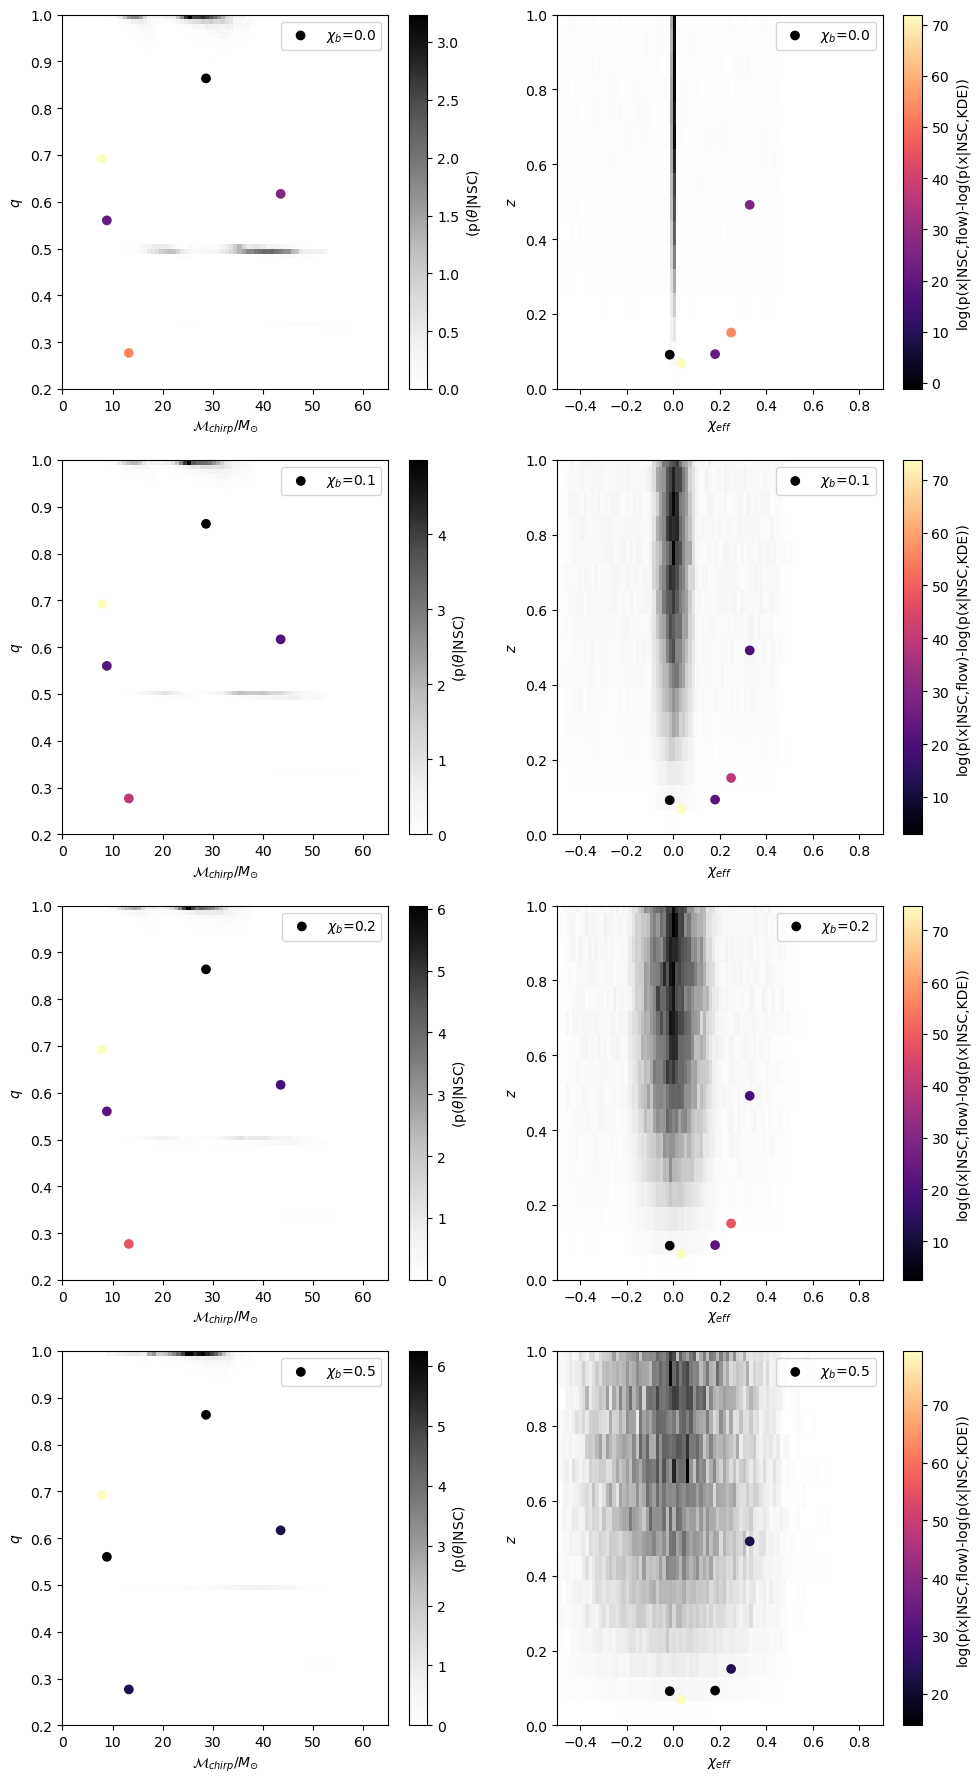

In [26]:
plt.rcParams["figure.figsize"] = (10,18)
fig, ax = plt.subplots(4,2)
for chibid in range(4):

    p_theta = ax[chibid,0].hist2d(popsynth_outputs[chibid]['mchirp'],popsynth_outputs[chibid]['q'], bins=100,\
         weights=popsynth_outputs[chibid]['weight'], cmap='Greys', density=True)
    ax[chibid,0].scatter(obsdata[:,:,0],obsdata[:,:,1], c=llh_ratio_kde_flow[chibid], cmap=cm.magma, label=fr'$\chi_b$={chi_b[chibid]}')
    ax[chibid,0].set_xlabel(r'$\mathcal{M}_{chirp} /M_{\odot}$')
    ax[chibid,0].set_ylabel(r'$q$')
    ax[chibid,0].set_ylim(0.2,1)
    ax[chibid,0].set_xlim(0,65)
    ax[chibid,0].legend()
    ax[chibid,1].hist2d(popsynth_outputs[chibid]['chieff'],popsynth_outputs[chibid]['z'], bins=100,\
         weights=popsynth_outputs[chibid]['weight'], cmap='Greys', density=True)
    sp=ax[chibid,1].scatter(obsdata[:,:,2],obsdata[:,:,3], c=llh_ratio_kde_flow[chibid], cmap=cm.magma, label=fr'$\chi_b$={chi_b[chibid]}')
    ax[chibid,1].set_ylim(0.,1)
    ax[chibid,1].set_xlim(-0.5,0.9)
    ax[chibid,1].set_xlabel(r'$\chi_{eff}$')
    ax[chibid,1].set_ylabel(r'$z$')
    ax[chibid,1].legend()
    #fig.colorbar(ax=ax[chibid,1], label='log(ptheta_flow)-log(ptheta_kde)')
    cbar = fig.colorbar(sp,ax=ax[chibid,1])
    cbar.set_label(fr'log(p(x|{channels[0]},flow)-log(p(x|{channels[0]},KDE))')
    cbar = fig.colorbar(p_theta[3],ax=ax[chibid,0])
    cbar.set_label(fr'(p($\theta$|{channels[0]})')

fig.tight_layout(pad=1.3)
#fig.savefig(f'llh_ratio/gw_events/KDE_flow_ratio/{channels[0]}_llhratio.pdf')

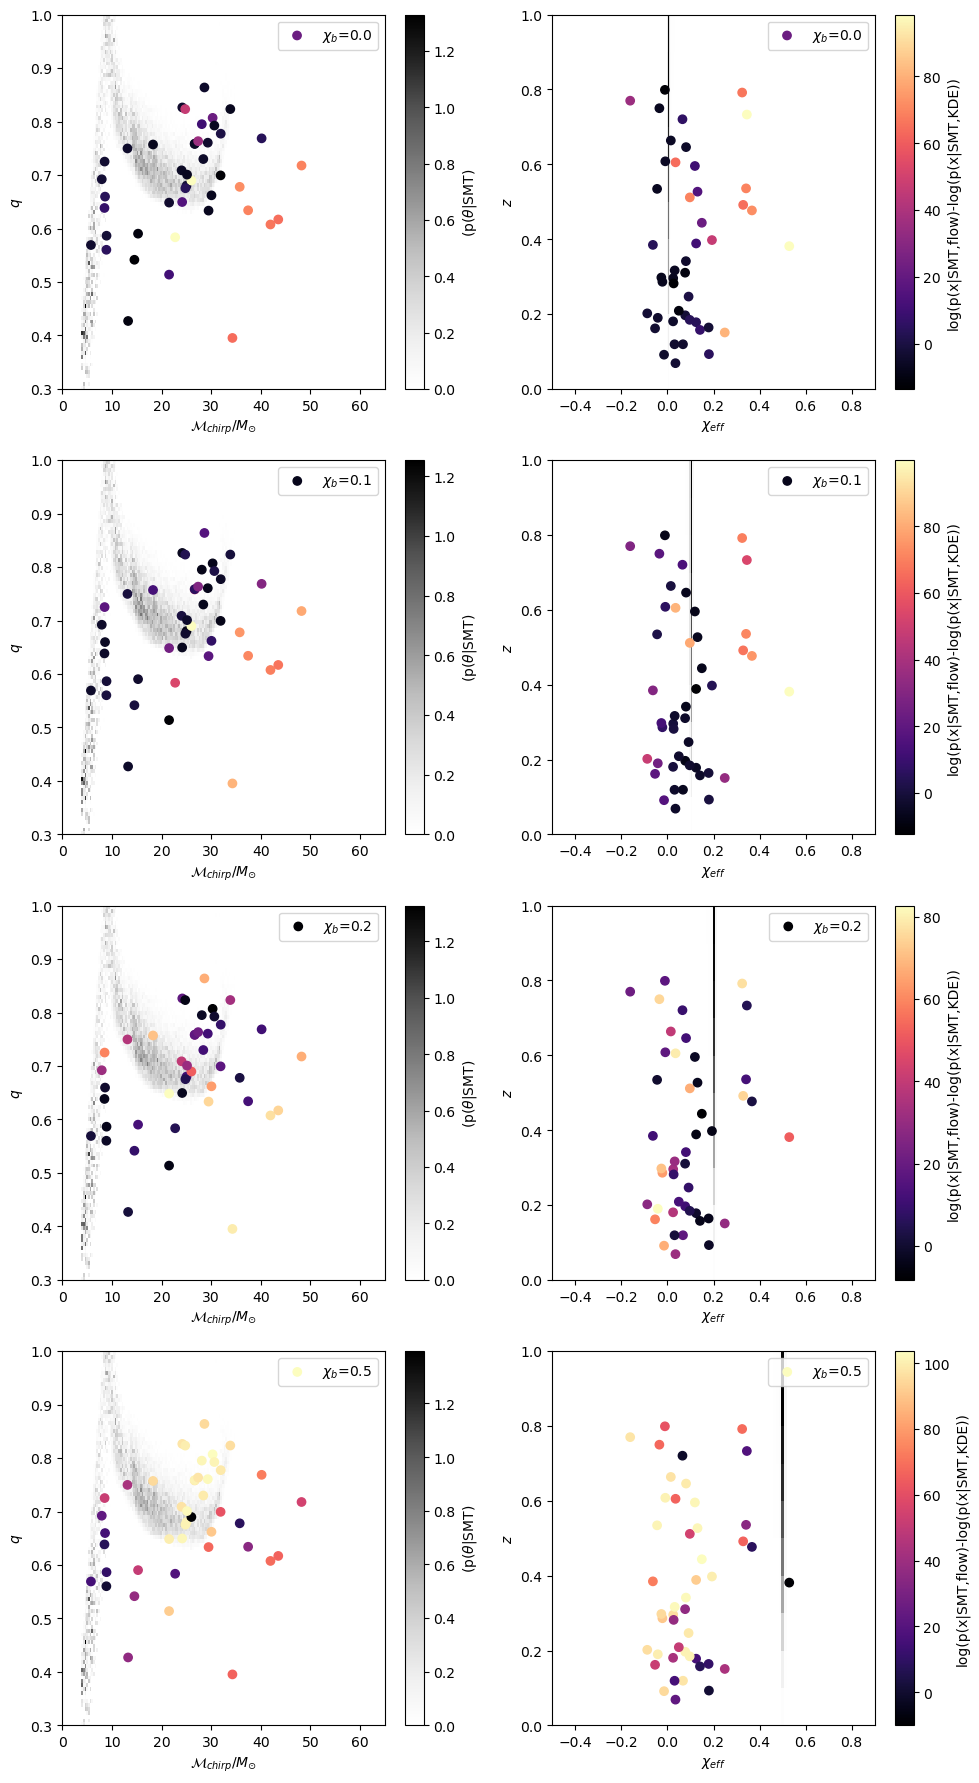

In [218]:
plt.rcParams["figure.figsize"] = (10,18)
fig, ax = plt.subplots(4,2)
for chibid in range(4):

    p_theta = ax[chibid,0].hist2d(popsynth_outputs[chibid]['mchirp'],popsynth_outputs[chibid]['q'], bins=100,\
         weights=popsynth_outputs[chibid]['weight'], cmap='Greys', density=True)
    ax[chibid,0].scatter(obsdata[:,:,0],obsdata[:,:,1], c=llh_ratio_kdeflow_flow[chibid], cmap=cm.magma, label=fr'$\chi_b$={chi_b[chibid]}')
    ax[chibid,0].set_xlabel(r'$\mathcal{M}_{chirp} /M_{\odot}$')
    ax[chibid,0].set_ylabel(r'$q$')
    ax[chibid,0].set_ylim(0.3,1)
    ax[chibid,0].set_xlim(0,65)
    ax[chibid,0].legend()
    ax[chibid,1].hist2d(popsynth_outputs[chibid]['chieff'],popsynth_outputs[chibid]['z'], bins=100,\
         weights=popsynth_outputs[chibid]['weight'], cmap='Greys', density=True)
    sp=ax[chibid,1].scatter(obsdata[:,:,2],obsdata[:,:,3], c=llh_ratio_kdeflow_flow[chibid], cmap=cm.magma, label=fr'$\chi_b$={chi_b[chibid]}')
    ax[chibid,1].set_ylim(0.,1)
    ax[chibid,1].set_xlim(-0.5,0.9)
    ax[chibid,1].set_xlabel(r'$\chi_{eff}$')
    ax[chibid,1].set_ylabel(r'$z$')
    ax[chibid,1].legend()
    #fig.colorbar(ax=ax[chibid,1], label='log(ptheta_flow)-log(ptheta_kde)')
    cbar = fig.colorbar(sp,ax=ax[chibid,1])
    cbar.set_label(fr'log(p(x|{channels[0]},flow)-log(p(x|{channels[0]},KDE))')
    cbar = fig.colorbar(p_theta[3],ax=ax[chibid,0])
    cbar.set_label(fr'(p($\theta$|{channels[0]})')

fig.tight_layout(pad=1.3)
fig.savefig(f'llh_ratio/gw_events/KDEflowsamples_flow_ratio/{channels[0]}_llhratio.pdf')

KeyError: 0

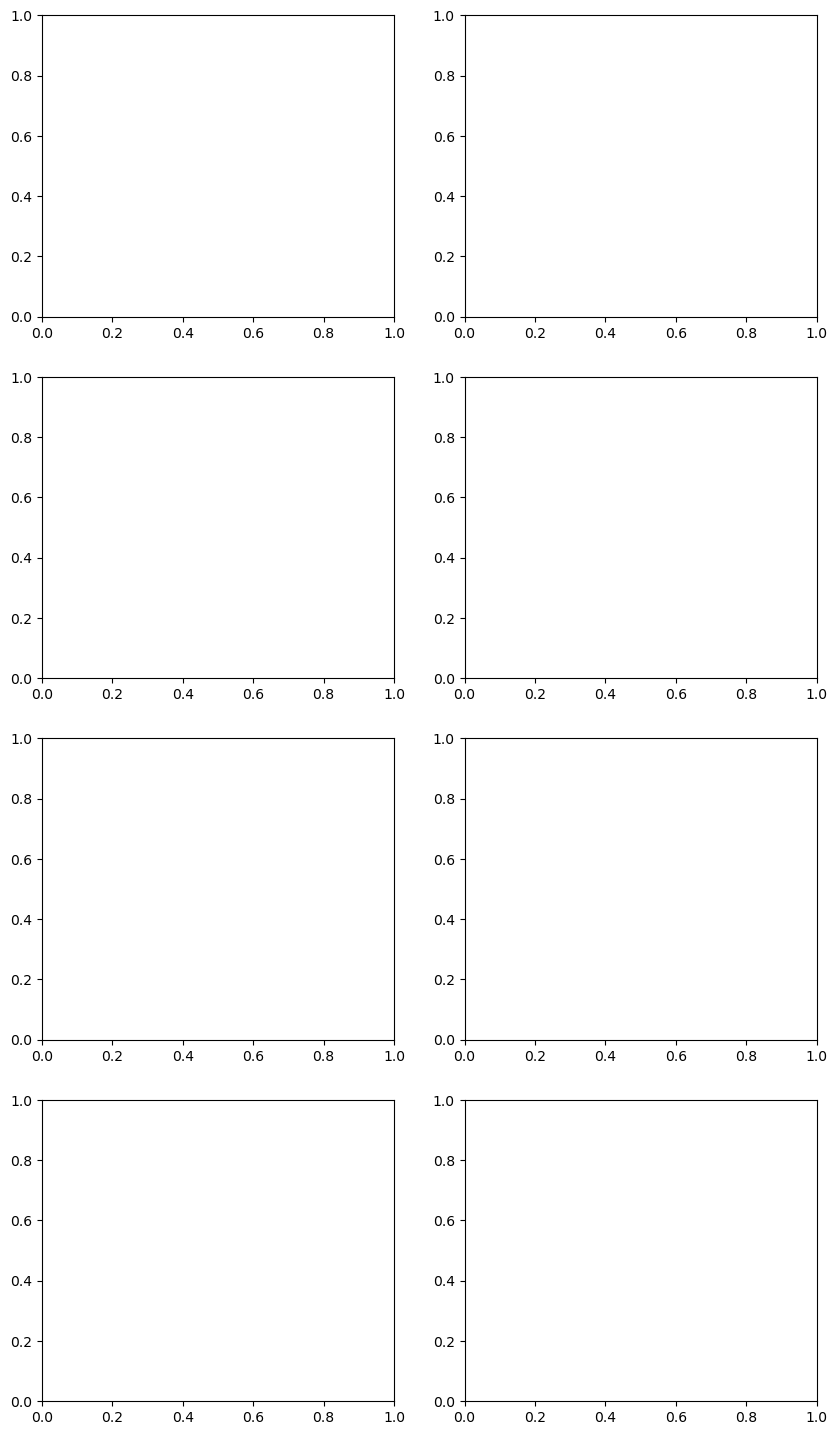

In [5]:
plt.rcParams["figure.figsize"] = (10,18)
fig, ax = plt.subplots(4,2)
for chibid in range(4):

    p_theta = ax[chibid,0].hist2d(popsynth_outputs[chibid]['mchirp'],popsynth_outputs[chibid]['q'], bins=100,\
         weights=popsynth_outputs[chibid]['weight'], cmap='Greys', density=True)
    ax[chibid,0].scatter(obsdata[:,:,0],obsdata[:,:,1], c=llh_ratio_kdeflow_kde[chibid], cmap=cm.magma, label=fr'$\chi_b$={chi_b[chibid]}')
    ax[chibid,0].set_xlabel(r'$\mathcal{M}_{chirp} /M_{\odot}$')
    ax[chibid,0].set_ylabel(r'$q$')
    ax[chibid,0].set_ylim(0.3,1)
    ax[chibid,0].set_xlim(0,65)
    ax[chibid,0].legend()
    ax[chibid,1].hist2d(popsynth_outputs[chibid]['chieff'],popsynth_outputs[chibid]['z'], bins=100,\
         weights=popsynth_outputs[chibid]['weight'], cmap='Greys', density=True)
    sp=ax[chibid,1].scatter(obsdata[:,:,2],obsdata[:,:,3], c=llh_ratio_kdeflow_kde[chibid], cmap=cm.magma, label=fr'$\chi_b$={chi_b[chibid]}')
    ax[chibid,1].set_ylim(0.,1)
    ax[chibid,1].set_xlim(-0.5,0.9)
    ax[chibid,1].set_xlabel(r'$\chi_{eff}$')
    ax[chibid,1].set_ylabel(r'$z$')
    ax[chibid,1].legend()
    #fig.colorbar(ax=ax[chibid,1], label='log(ptheta_flow)-log(ptheta_kde)')
    cbar = fig.colorbar(sp,ax=ax[chibid,1])
    cbar.set_label(fr'log(p(x|{channels[0]},flow)-log(p(x|{channels[0]},KDE))')
    cbar = fig.colorbar(p_theta[3],ax=ax[chibid,0])
    cbar.set_label(fr'(p($\theta$|{channels[0]})')

fig.tight_layout(pad=1.3)
fig.savefig(f'llh_ratio/gw_events/KDEflowsamples_KDE_ratio/{channels[0]}_llhratio.pdf')

# CE Channel

In [11]:
llh_ratio_kde_flow = np.zeros((4,5,obsdata.shape[0]))
llh_ratio_kdeflow_flow = np.zeros((4,5,obsdata.shape[0]))
llh_ratio_kdeflow_kde = np.zeros((4,5,obsdata.shape[0]))
for chibid in range(4):
    for alphaid in range(5):
        for i,obs in enumerate(obsdata):
            obs = np.reshape(obs, (1,1,4))
            print(obs)
            lnlike_flow_theta=sample.lnlike([chibid,alphaid],obs, flow, submodels_dict, channels, use_flows=True, prior_pdf=np.array([p_theta[i]]))
            lnlike_kde_theta=sample.lnlike([chibid,alphaid],obs, KDE, submodels_dict, channels, use_flows=False, prior_pdf=[p_theta[i]])
            lnlike_kdeflow_theta=sample.lnlike([chibid,alphaid],obs, KDE_flowsamps, submodels_dict, channels, use_flows=False, prior_pdf=[p_theta[i]])
            llh_ratio_kde_flow[chibid,alphaid,i] = lnlike_flow_theta-lnlike_kde_theta
            llh_ratio_kdeflow_flow[chibid,alphaid,i] = lnlike_flow_theta-lnlike_kdeflow_theta
            llh_ratio_kdeflow_kde[chibid,alphaid,i] = lnlike_kde_theta-lnlike_kdeflow_theta

[[[ 2.86412235e+01  8.63770465e-01 -1.49326274e-02  9.15105871e-02]]]
[[[8.86715358 0.56026687 0.18001728 0.09306373]]]
[[[7.93929444 0.69213385 0.03459616 0.06888004]]]
[[[43.53277921  0.61694006  0.32875775  0.49173582]]]
[[[13.25497086  0.27694384  0.24878645  0.15087001]]]
[[[ 2.86412235e+01  8.63770465e-01 -1.49326274e-02  9.15105871e-02]]]
[[[8.86715358 0.56026687 0.18001728 0.09306373]]]
[[[7.93929444 0.69213385 0.03459616 0.06888004]]]
[[[43.53277921  0.61694006  0.32875775  0.49173582]]]
[[[13.25497086  0.27694384  0.24878645  0.15087001]]]
[[[ 2.86412235e+01  8.63770465e-01 -1.49326274e-02  9.15105871e-02]]]
[[[8.86715358 0.56026687 0.18001728 0.09306373]]]
[[[7.93929444 0.69213385 0.03459616 0.06888004]]]
[[[43.53277921  0.61694006  0.32875775  0.49173582]]]
[[[13.25497086  0.27694384  0.24878645  0.15087001]]]
[[[ 2.86412235e+01  8.63770465e-01 -1.49326274e-02  9.15105871e-02]]]
[[[8.86715358 0.56026687 0.18001728 0.09306373]]]
[[[7.93929444 0.69213385 0.03459616 0.06888004

## Log ratio between KDE and flow

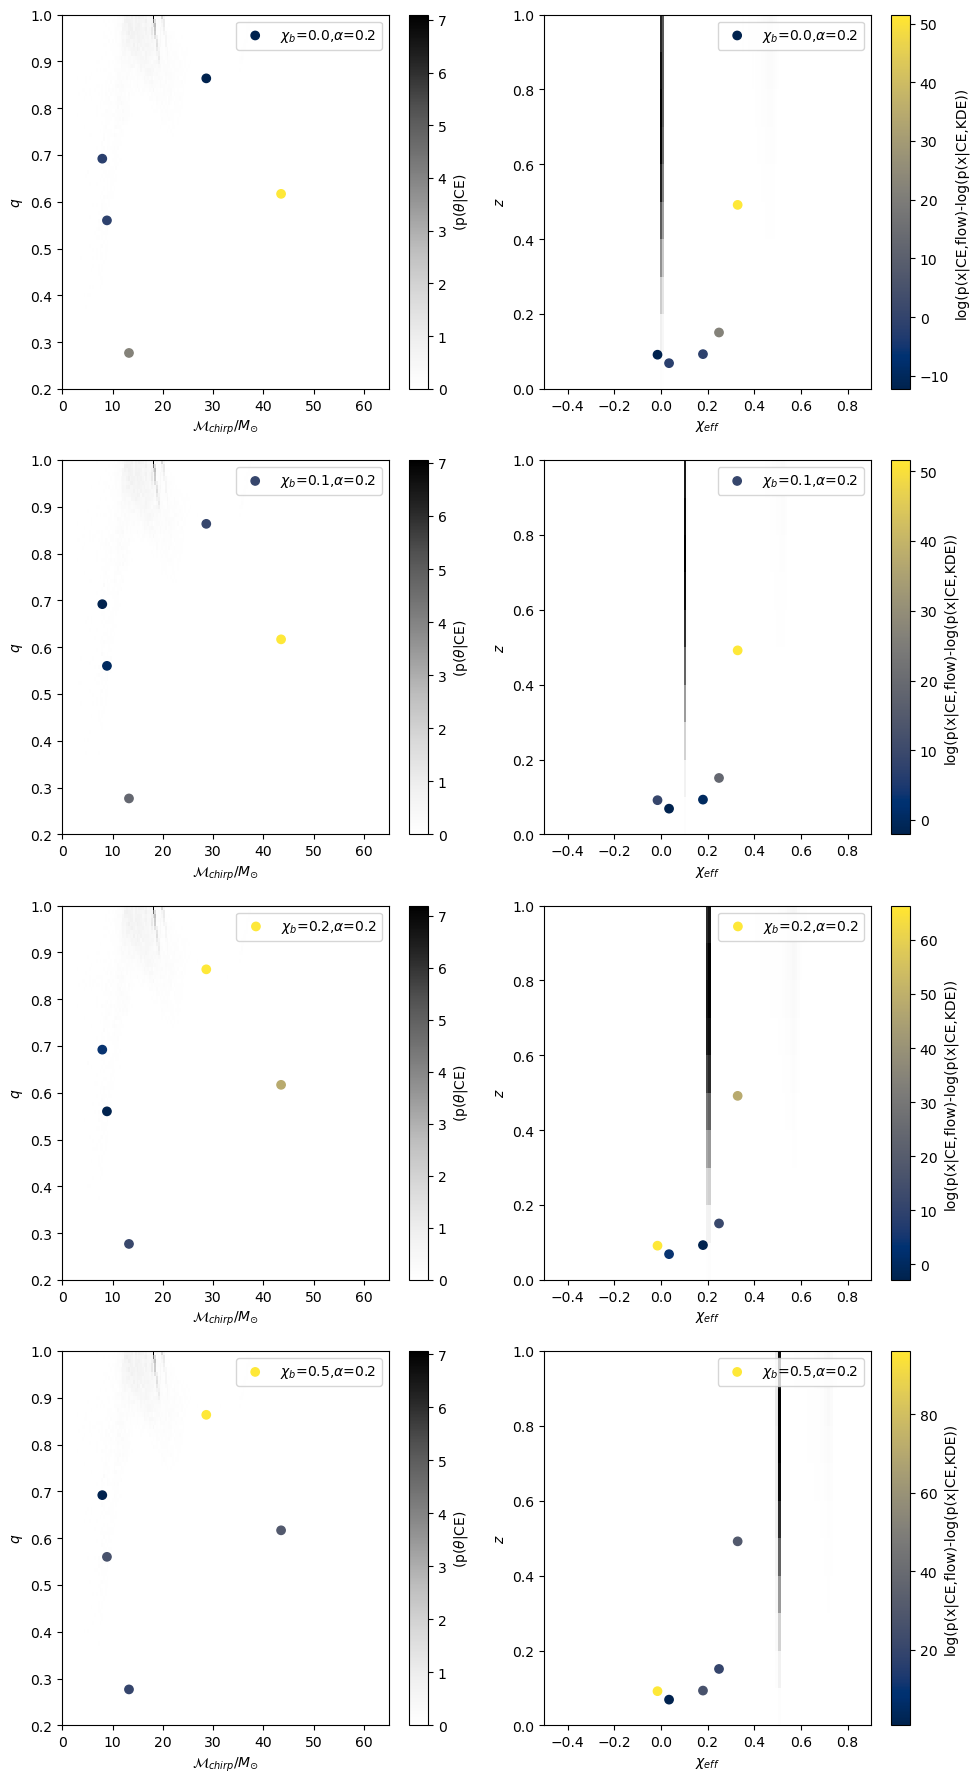

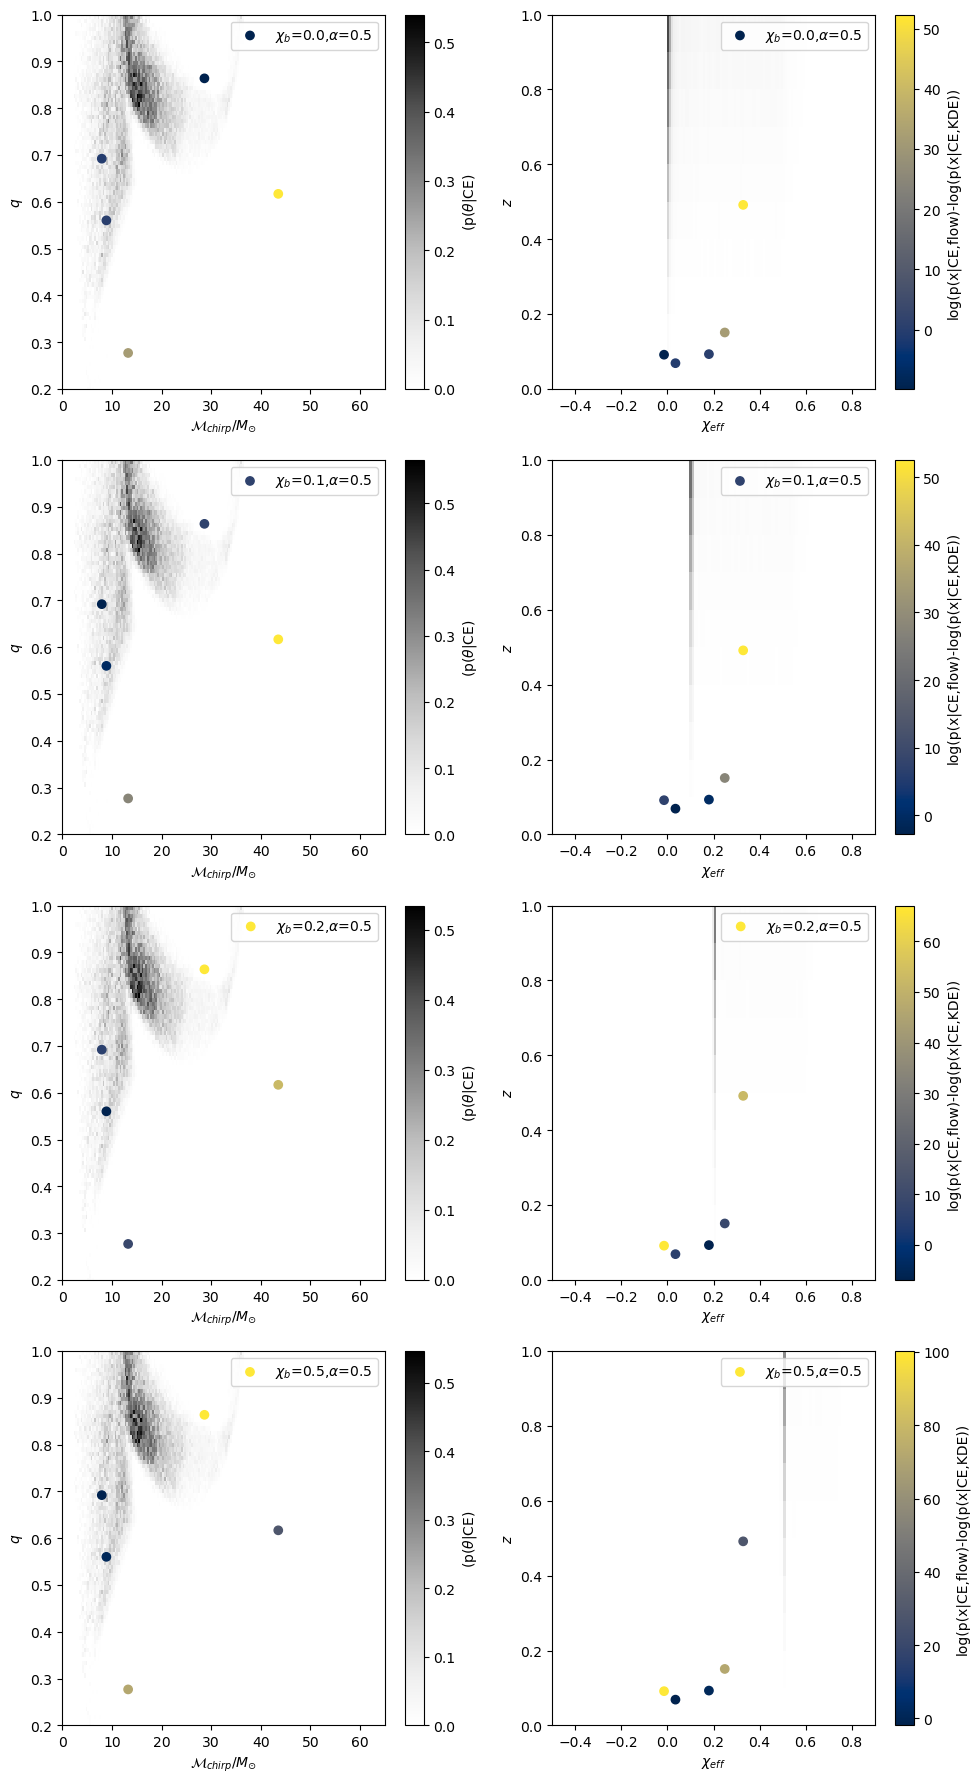

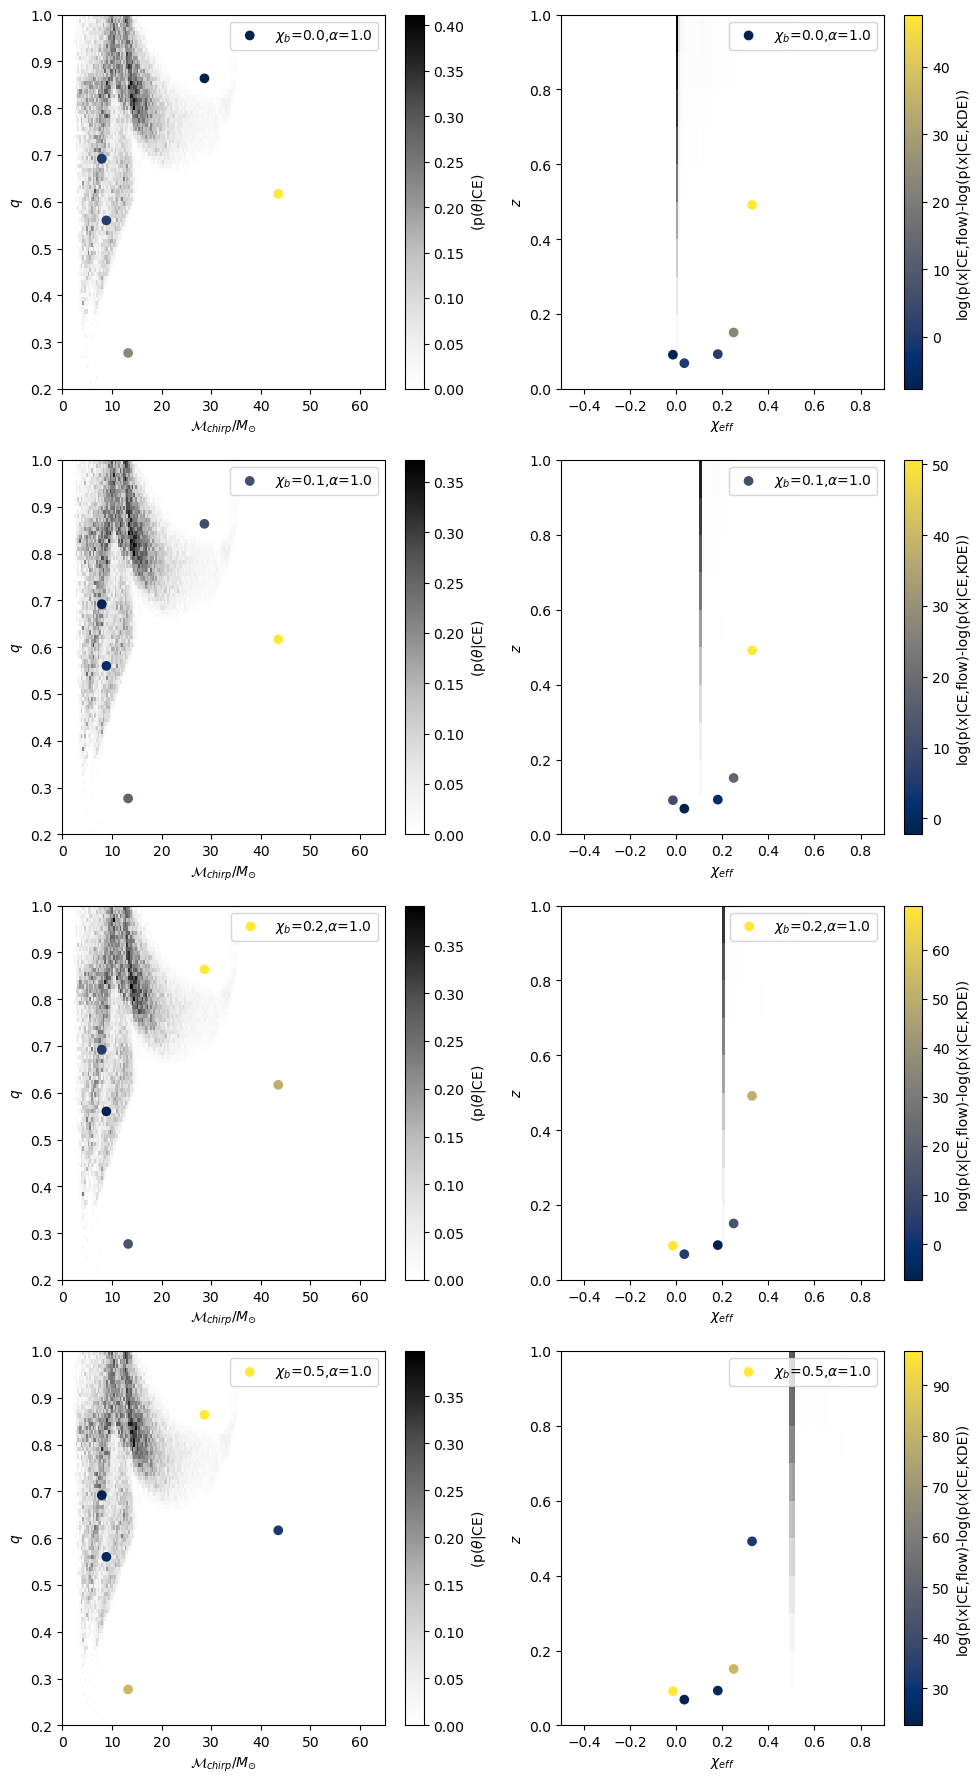

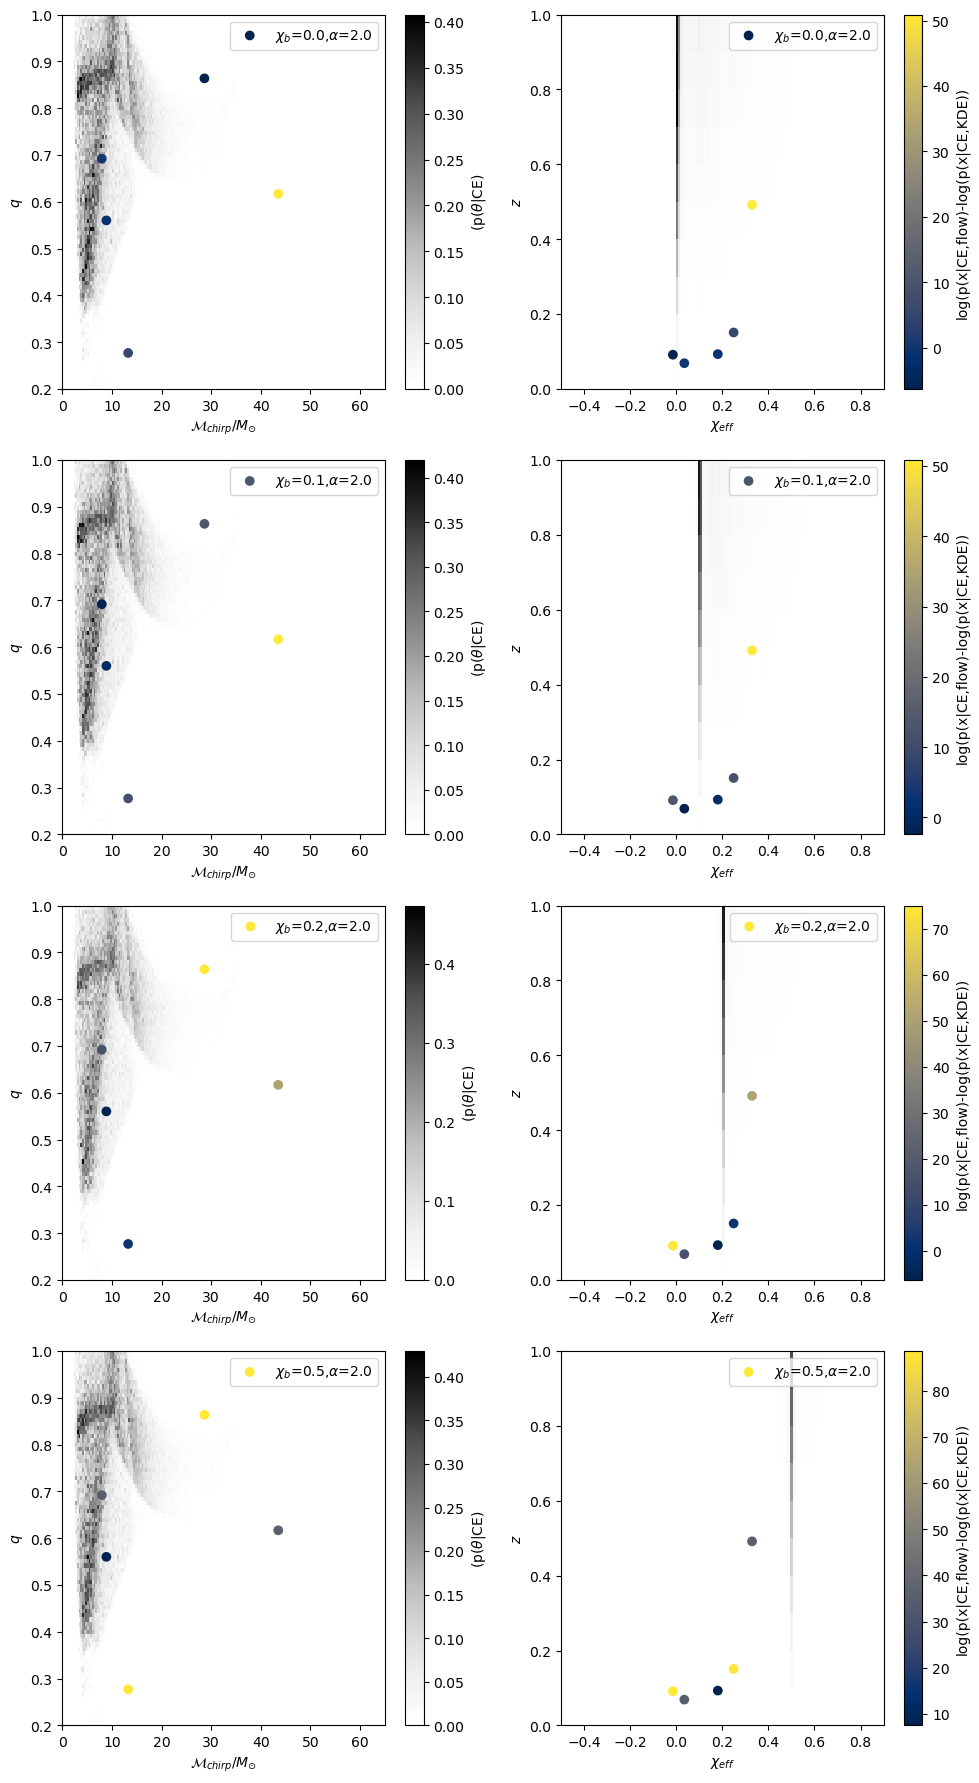

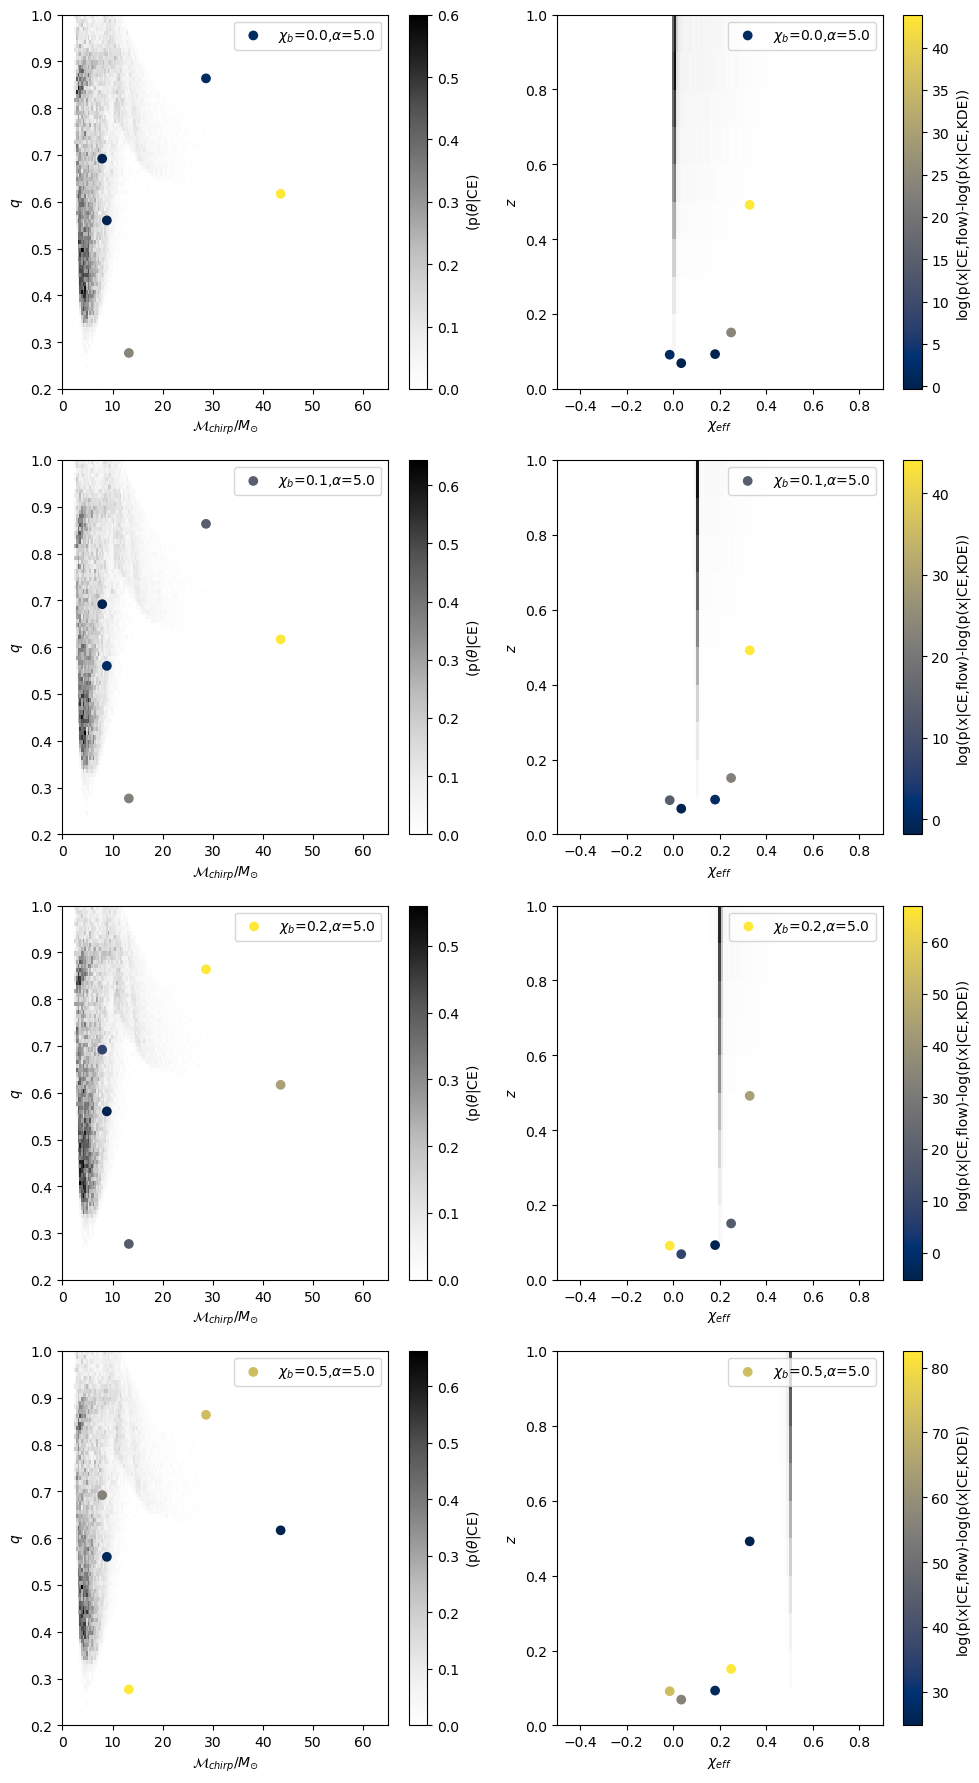

In [12]:
plt.rcParams["figure.figsize"] = (10,18)
for alphaid in range(5):
    fig, ax = plt.subplots(4,2)
    for chibid in range(4):

        p_theta = ax[chibid,0].hist2d(popsynth_outputs[chibid,alphaid]['mchirp'],popsynth_outputs[chibid,alphaid]['q'], bins=100,\
            weights=popsynth_outputs[chibid,alphaid]['weight'], cmap='Greys', density=True)
        ax[chibid,0].scatter(obsdata[:,:,0],obsdata[:,:,1], c=llh_ratio_kde_flow[chibid,alphaid], cmap=cm.cividis, label=fr'$\chi_b$={chi_b[chibid]},$\alpha$={alpha[alphaid]}')
        ax[chibid,0].set_xlabel(r'$\mathcal{M}_{chirp} /M_{\odot}$')
        ax[chibid,0].set_ylabel(r'$q$')
        ax[chibid,0].set_ylim(0.2,1)
        ax[chibid,0].set_xlim(0,65)
        ax[chibid,0].legend()
        ax[chibid,1].hist2d(popsynth_outputs[chibid,alphaid]['chieff'],popsynth_outputs[chibid,alphaid]['z'], bins=100,\
            weights=popsynth_outputs[chibid,alphaid]['weight'], cmap='Greys', density=True)
        sp=ax[chibid,1].scatter(obsdata[:,:,2],obsdata[:,:,3], c=llh_ratio_kde_flow[chibid,alphaid], cmap=cm.cividis, label=fr'$\chi_b$={chi_b[chibid]},$\alpha$={alpha[alphaid]}')
        ax[chibid,1].set_ylim(0.,1)
        ax[chibid,1].set_xlim(-0.5,0.9)
        ax[chibid,1].set_xlabel(r'$\chi_{eff}$')
        ax[chibid,1].set_ylabel(r'$z$')
        ax[chibid,1].legend()
        #fig.colorbar(ax=ax[chibid,1], label='log(ptheta_flow)-log(ptheta_kde)')
        cbar = fig.colorbar(sp,ax=ax[chibid,1])
        cbar.set_label(fr'log(p(x|{channels[0]},flow)-log(p(x|{channels[0]},KDE))')
        cbar = fig.colorbar(p_theta[3],ax=ax[chibid,0])
        cbar.set_label(fr'(p($\theta$|{channels[0]})')

    fig.tight_layout(pad=1.3)
    #fig.savefig(f'{channels[0]}_llhratio_simevents_2_chi00_alpha{alphaid}.pdf')

## Log ratio between KDE and flow marginalising over alpha

In [ ]:
llh_ratio_kde_flow = np.zeros((4,obsdata.shape[0]))
for chibid in range(4):
    for alphaid in range(5):
        for i,obs in enumerate(obsdata):
            obs = np.reshape(obs, (1,1,4))
            lnlike_flow_theta=logsumexp([lnlike_flow_theta,sample.lnlike([chibid,alphaid],obs, flow, submodels_dict, channels, use_flows=True, prior_pdf=np.array([p_theta[i]]))], axis=(0,1))
            lnlike_kde_theta=sample.lnlike([chibid,alphaid],obs, KDE, submodels_dict, channels, use_flows=False, prior_pdf=[p_theta[i]])
            llh_ratio_kde_flow[chibid,alphaid,i] = lnlike_flow_theta-lnlike_kde_theta

In [ ]:
plt.rcParams["figure.figsize"] = (10,18)

fig, ax = plt.subplots(4,2)
for alphaid in range(5):
    for chibid in range(4):

        p_theta = ax[chibid,0].hist2d(popsynth_outputs[chibid,alphaid]['mchirp'],popsynth_outputs[chibid,alphaid]['q'], bins=100,\
            weights=popsynth_outputs[chibid,alphaid]['weight'], cmap='Greys', density=True)
        ax[chibid,0].scatter(obsdata[:,:,0],obsdata[:,:,1], c=llh_ratio_kde_flow[chibid,alphaid], cmap=cm.cividis, label=fr'$\chi_b$={chi_b[chibid]},$\alpha$={alpha[alphaid]}')
        ax[chibid,0].set_xlabel(r'$\mathcal{M}_{chirp} /M_{\odot}$')
        ax[chibid,0].set_ylabel(r'$q$')
        ax[chibid,0].set_ylim(0.3,1)
        ax[chibid,0].set_xlim(0,65)
        ax[chibid,0].legend()
        ax[chibid,1].hist2d(popsynth_outputs[chibid,alphaid]['chieff'],popsynth_outputs[chibid,alphaid]['z'], bins=100,\
            weights=popsynth_outputs[chibid,alphaid]['weight'], cmap='Greys', density=True)
        sp=ax[chibid,1].scatter(obsdata[:,:,2],obsdata[:,:,3], c=llh_ratio_kde_flow[chibid,alphaid], cmap=cm.cividis, label=fr'$\chi_b$={chi_b[chibid]},$\alpha$={alpha[alphaid]}')
        ax[chibid,1].set_ylim(0.,1)
        ax[chibid,1].set_xlim(-0.5,0.9)
        ax[chibid,1].set_xlabel(r'$\chi_{eff}$')
        ax[chibid,1].set_ylabel(r'$z$')
        ax[chibid,1].legend()
        #fig.colorbar(ax=ax[chibid,1], label='log(ptheta_flow)-log(ptheta_kde)')
        cbar = fig.colorbar(sp,ax=ax[chibid,1])
        cbar.set_label(fr'log(p(x|{channels[0]},flow)-log(p(x|{channels[0]},KDE))')
        cbar = fig.colorbar(p_theta[3],ax=ax[chibid,0])
        cbar.set_label(fr'(p($\theta$|{channels[0]})')

    fig.tight_layout(pad=1.3)
    #fig.savefig(f'{channels[0]}_llhratio_simevents_2_chi00_alpha{alphaid}.pdf')

## Log ratio between KDE constructed from flow points and flow

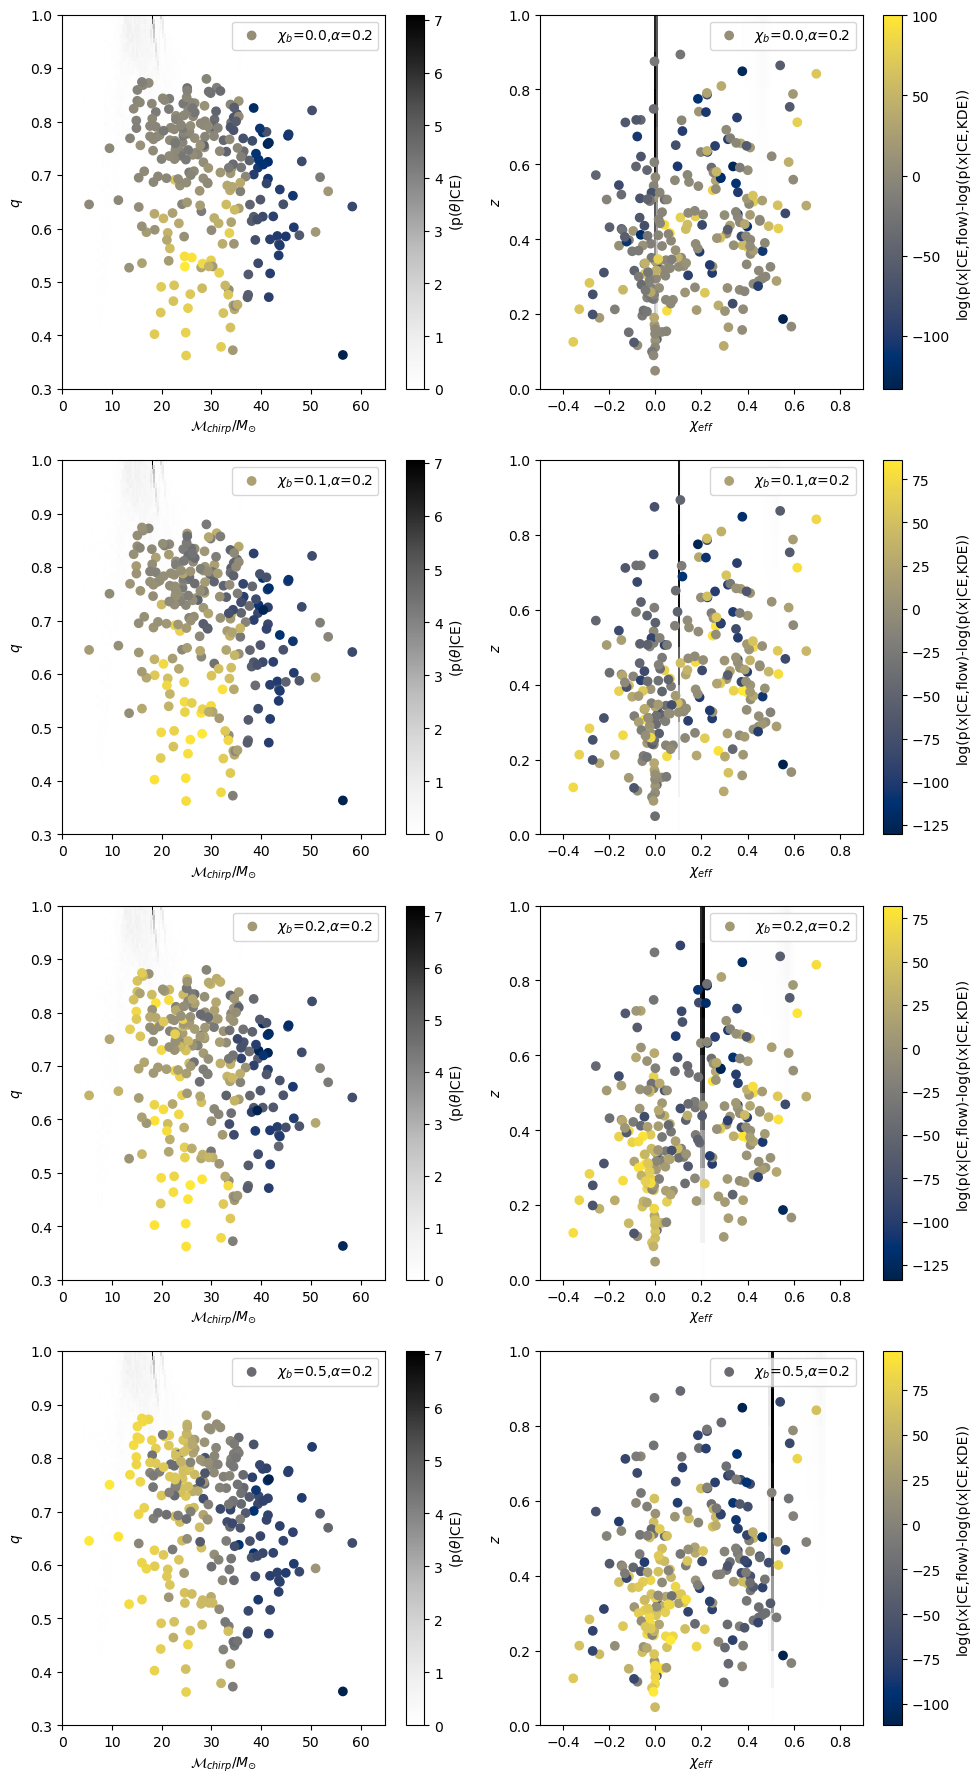

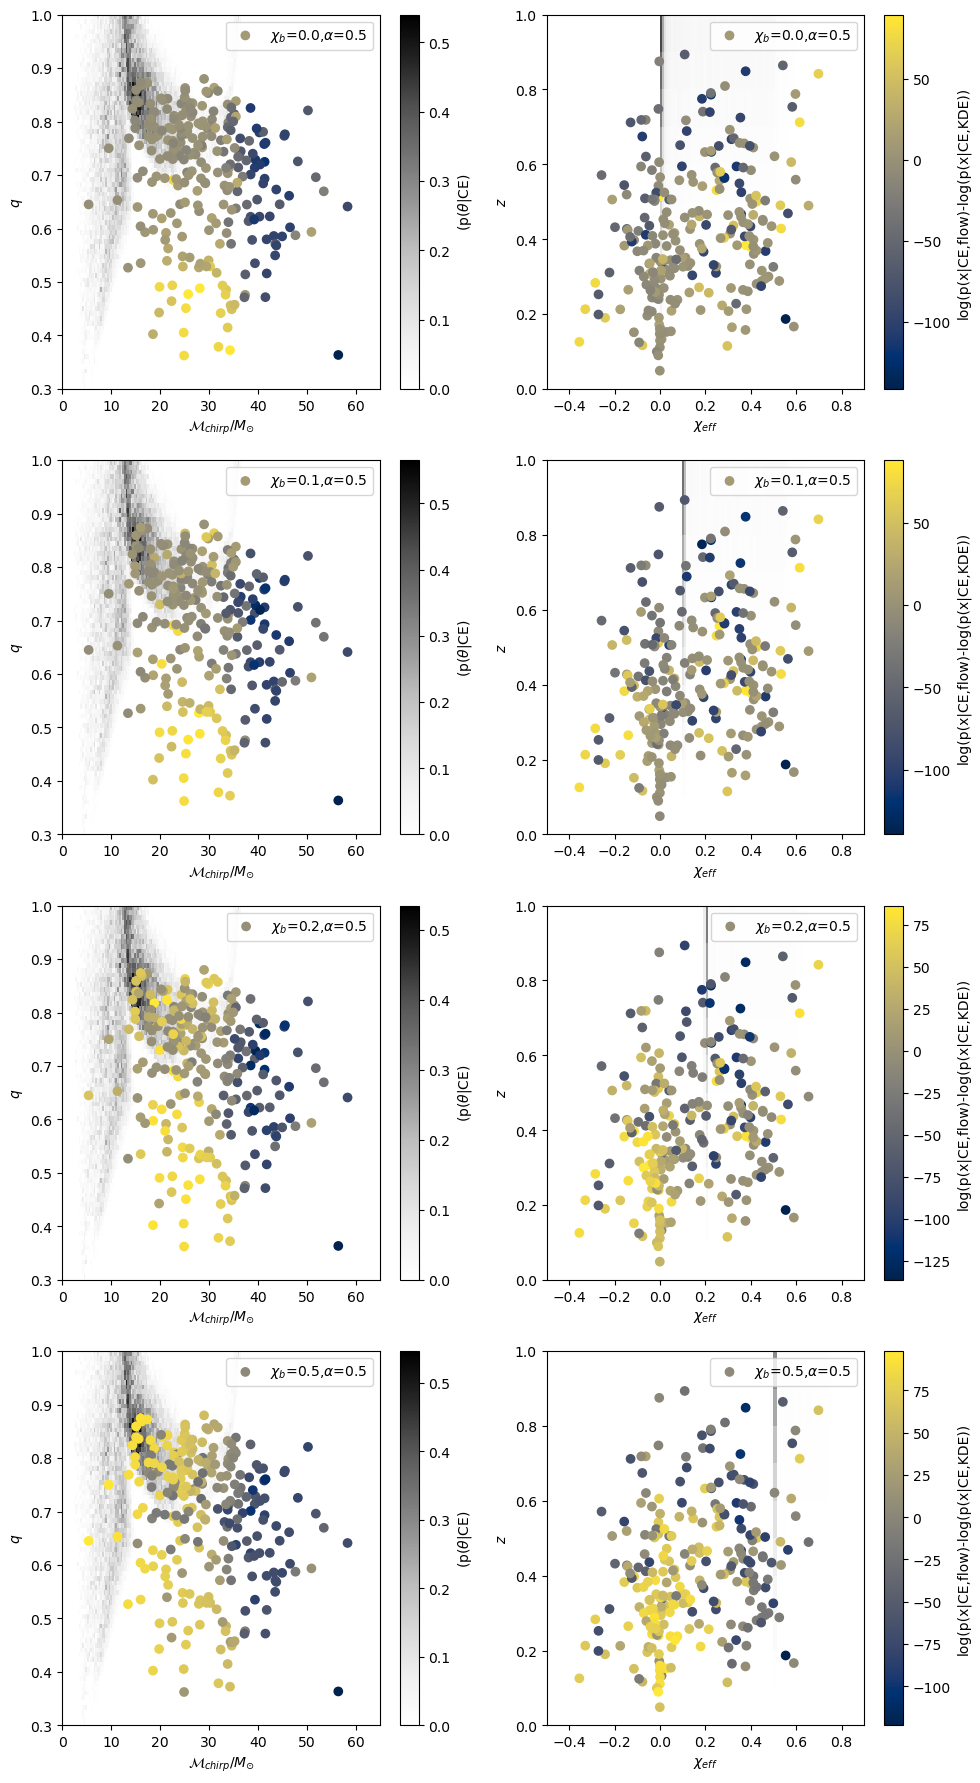

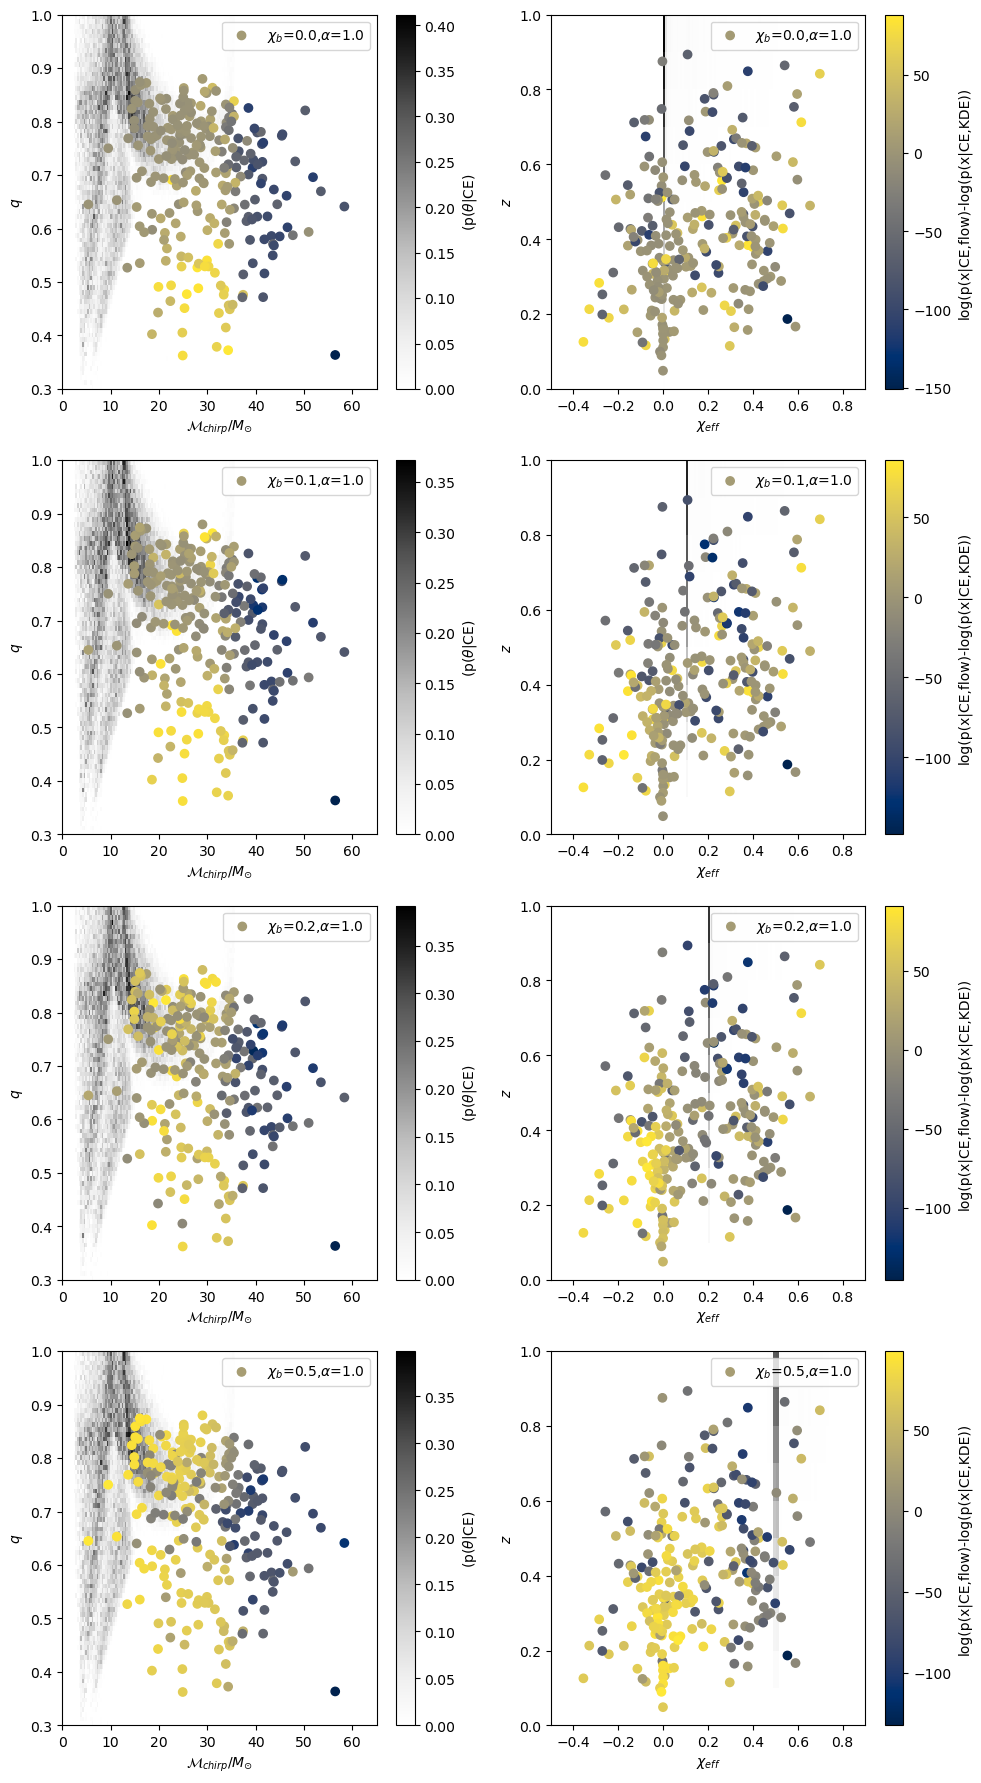

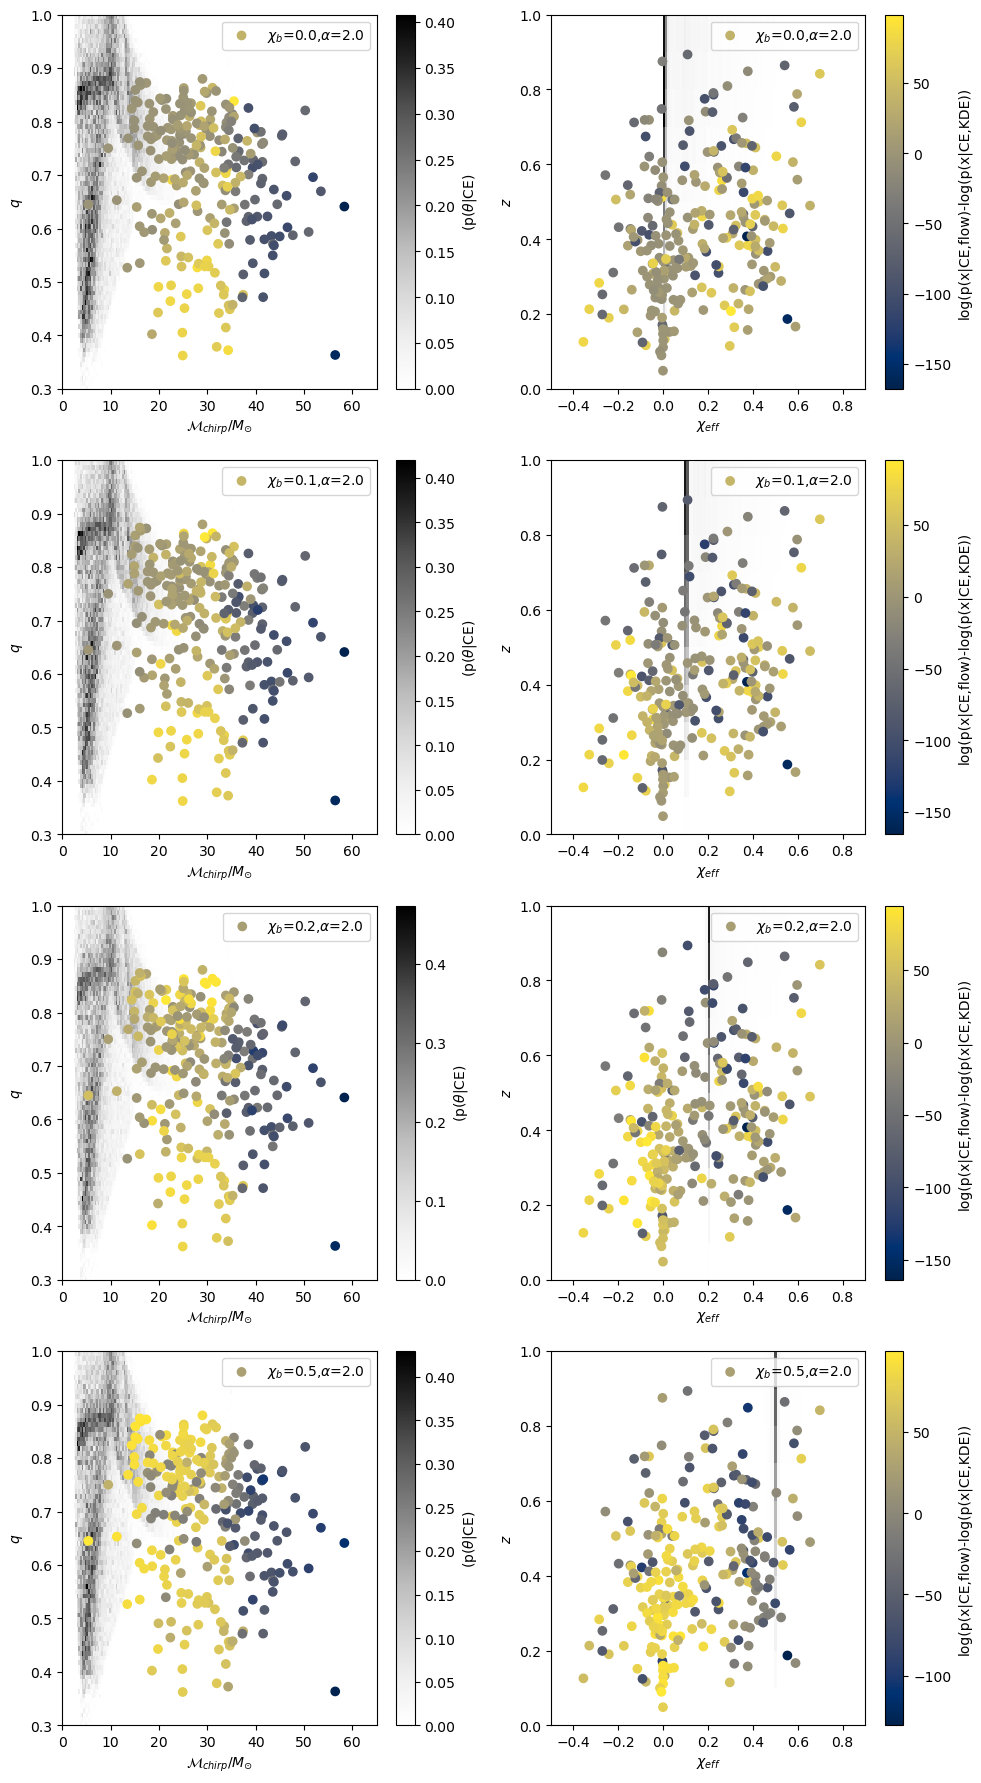

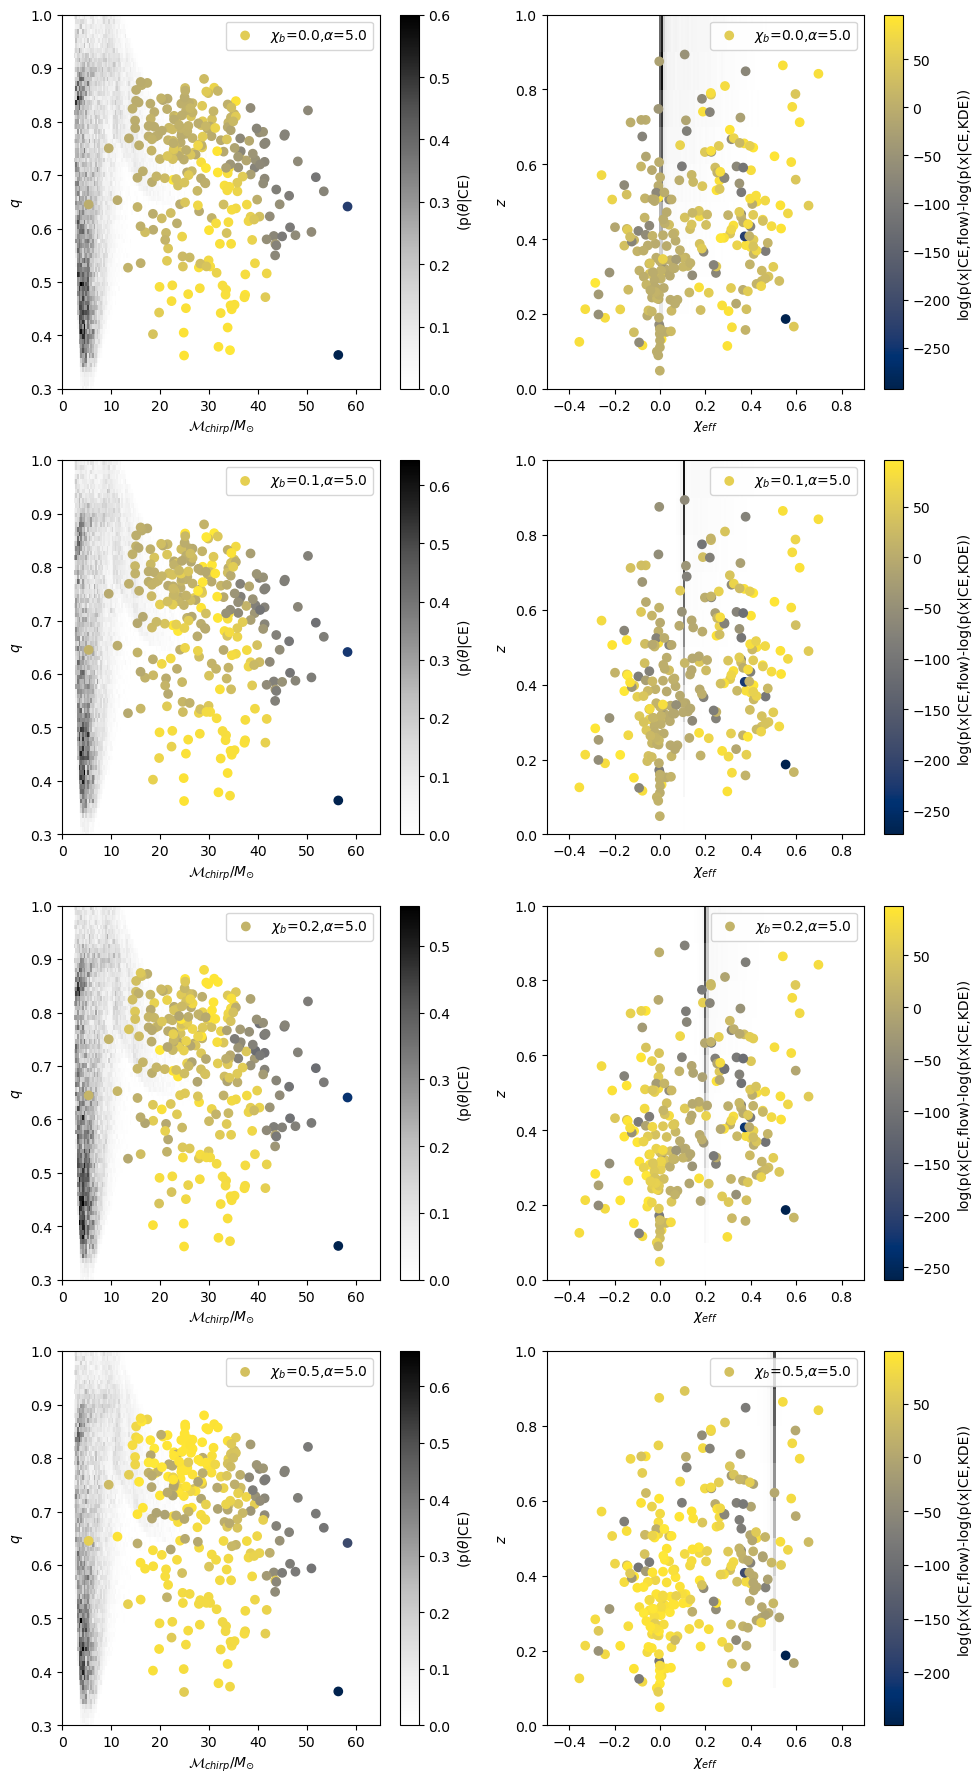

In [153]:
plt.rcParams["figure.figsize"] = (10,18)
for alphaid in range(5):
    fig, ax = plt.subplots(4,2)
    for chibid in range(4):

        p_theta = ax[chibid,0].hist2d(popsynth_outputs[chibid,alphaid]['mchirp'],popsynth_outputs[chibid,alphaid]['q'], bins=100,\
            weights=popsynth_outputs[chibid,alphaid]['weight'], cmap='Greys', density=True)
        ax[chibid,0].scatter(obsdata[:,:,0],obsdata[:,:,1], c=llh_ratio_kdeflow_flow[chibid,alphaid], cmap=cm.cividis, label=fr'$\chi_b$={chi_b[chibid]},$\alpha$={alpha[alphaid]}')
        ax[chibid,0].set_xlabel(r'$\mathcal{M}_{chirp} /M_{\odot}$')
        ax[chibid,0].set_ylabel(r'$q$')
        ax[chibid,0].set_ylim(0.3,1)
        ax[chibid,0].set_xlim(0,65)
        ax[chibid,0].legend()
        ax[chibid,1].hist2d(popsynth_outputs[chibid,alphaid]['chieff'],popsynth_outputs[chibid,alphaid]['z'], bins=100,\
            weights=popsynth_outputs[chibid,alphaid]['weight'], cmap='Greys', density=True)
        sp=ax[chibid,1].scatter(obsdata[:,:,2],obsdata[:,:,3], c=llh_ratio_kdeflow_flow[chibid,alphaid], cmap=cm.cividis, label=fr'$\chi_b$={chi_b[chibid]},$\alpha$={alpha[alphaid]}')
        ax[chibid,1].set_ylim(0.,1)
        ax[chibid,1].set_xlim(-0.5,0.9)
        ax[chibid,1].set_xlabel(r'$\chi_{eff}$')
        ax[chibid,1].set_ylabel(r'$z$')
        ax[chibid,1].legend()
        #fig.colorbar(ax=ax[chibid,1], label='log(ptheta_flow)-log(ptheta_kde)')
        cbar = fig.colorbar(sp,ax=ax[chibid,1])
        cbar.set_label(fr'log(p(x|{channels[0]},flow)-log(p(x|{channels[0]},KDE))')
        cbar = fig.colorbar(p_theta[3],ax=ax[chibid,0])
        cbar.set_label(fr'(p($\theta$|{channels[0]})')

    fig.tight_layout(pad=1.3)
    fig.savefig(f'{channels[0]}_llhratio_simevents_2_chi00_alpha{alphaid}_kdeflow_flow.pdf')

## Log ratio between KDE constructed from flow samples and KDE

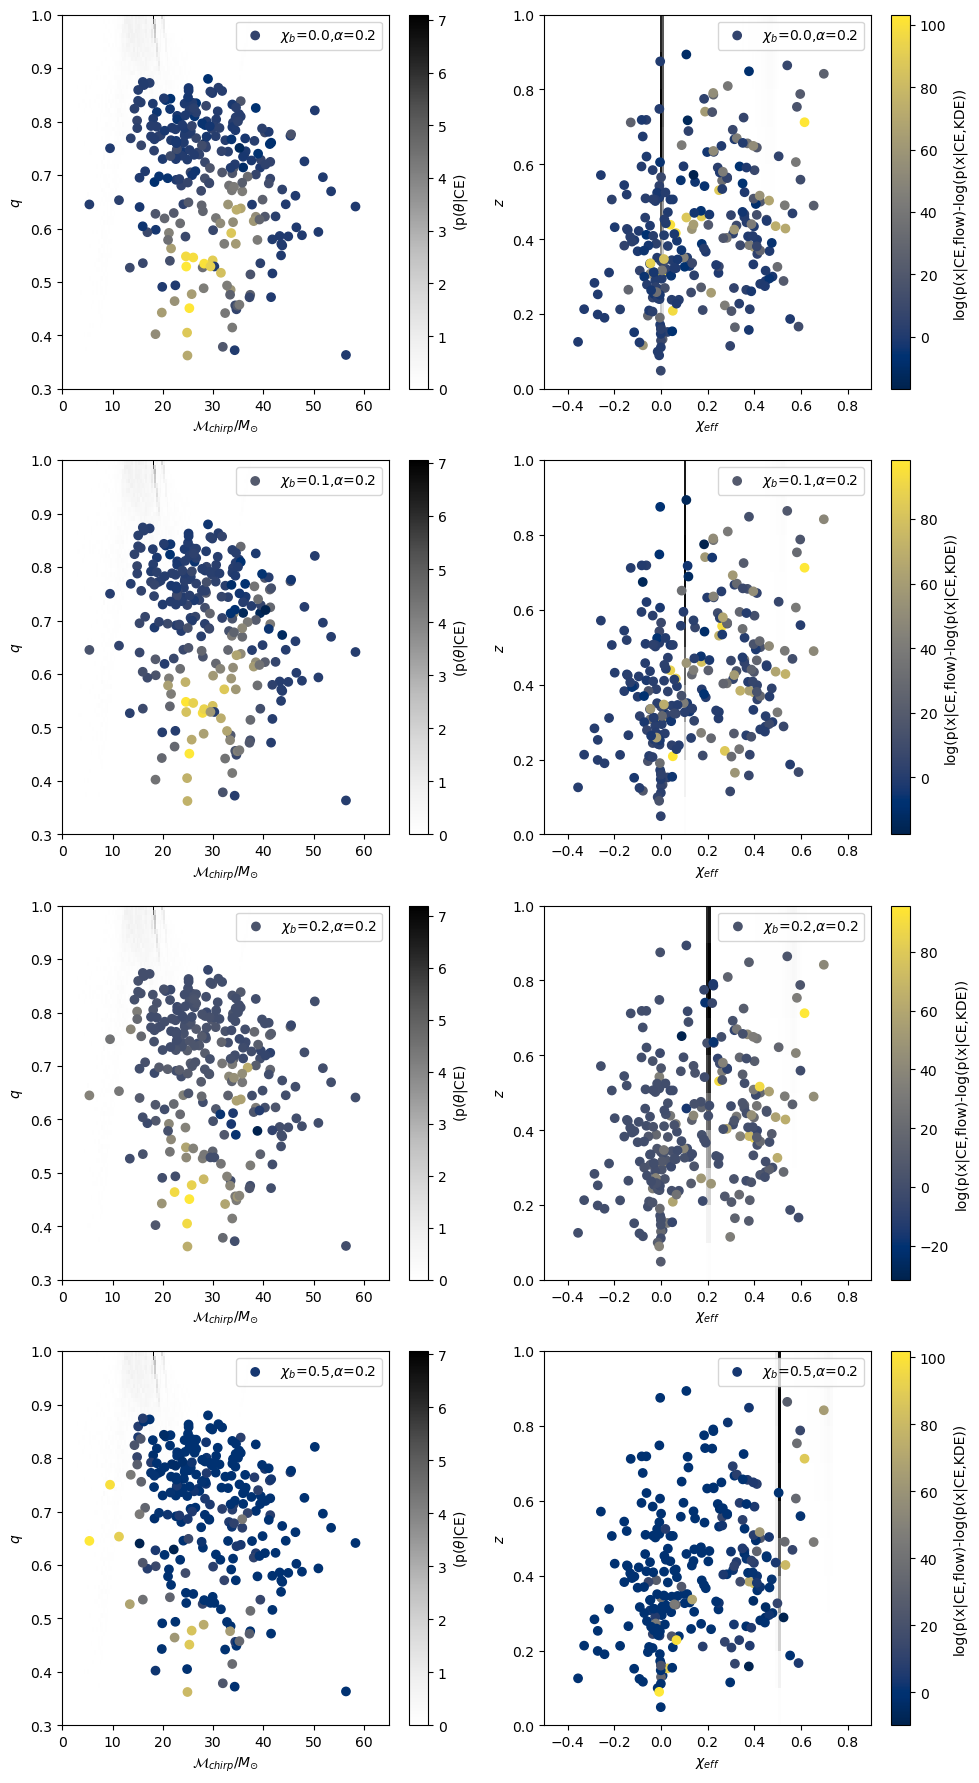

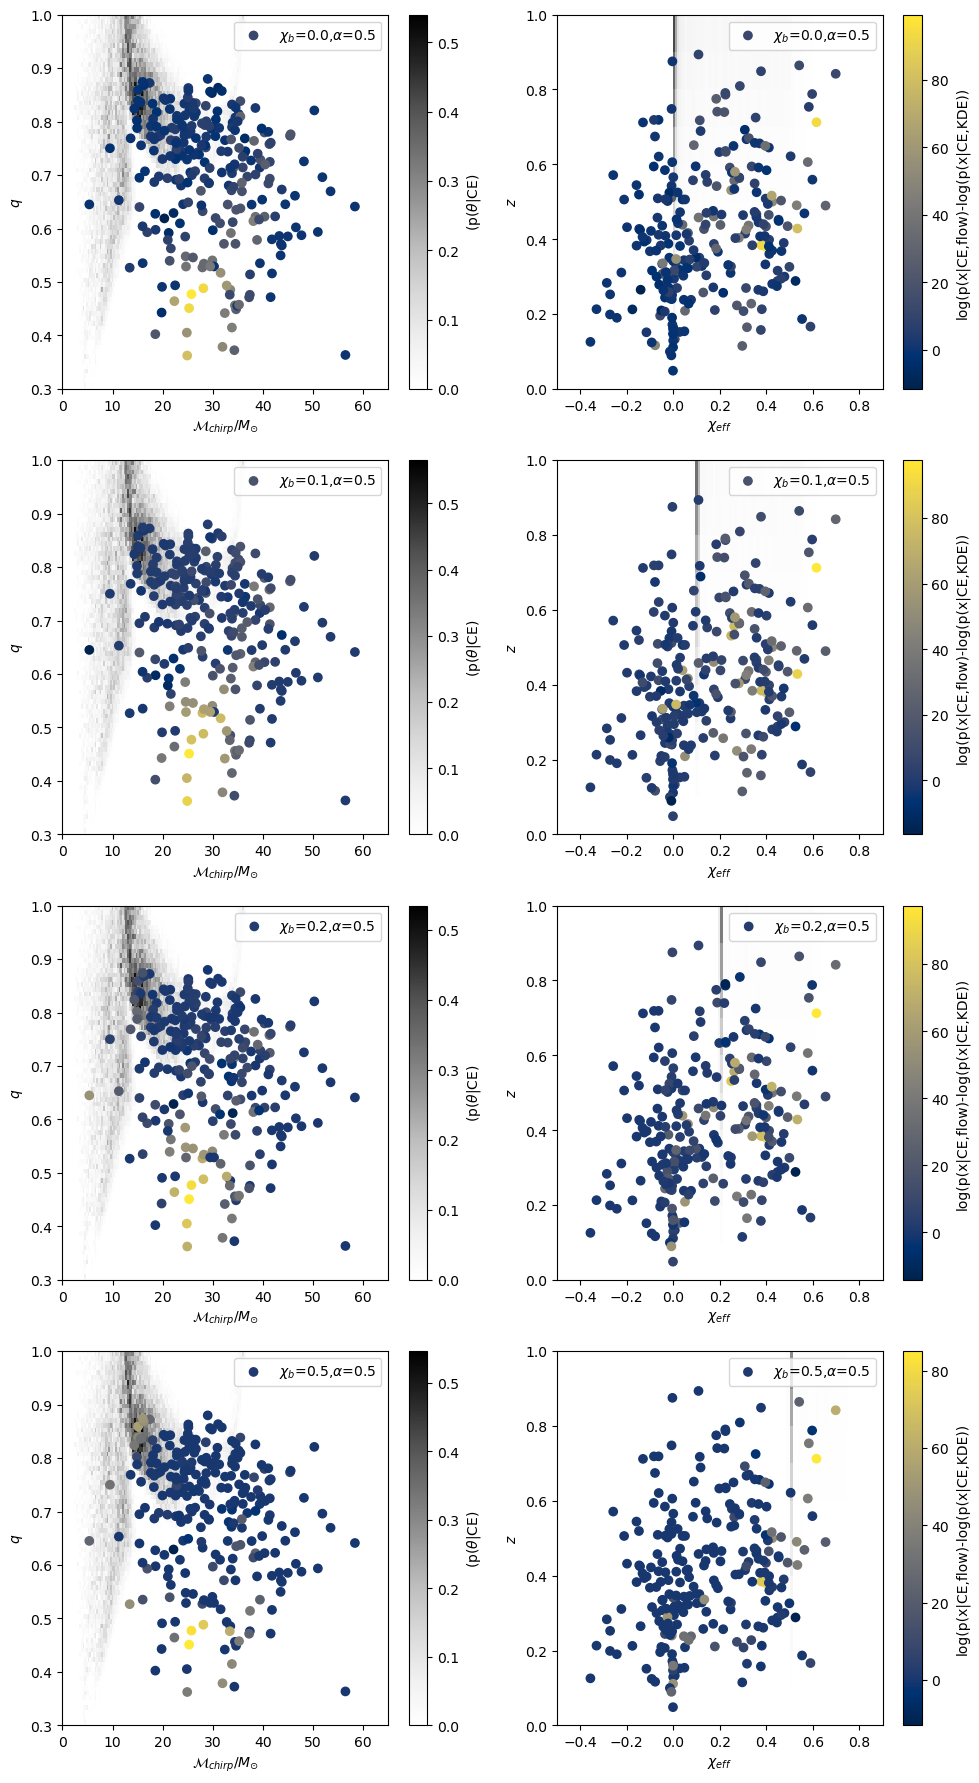

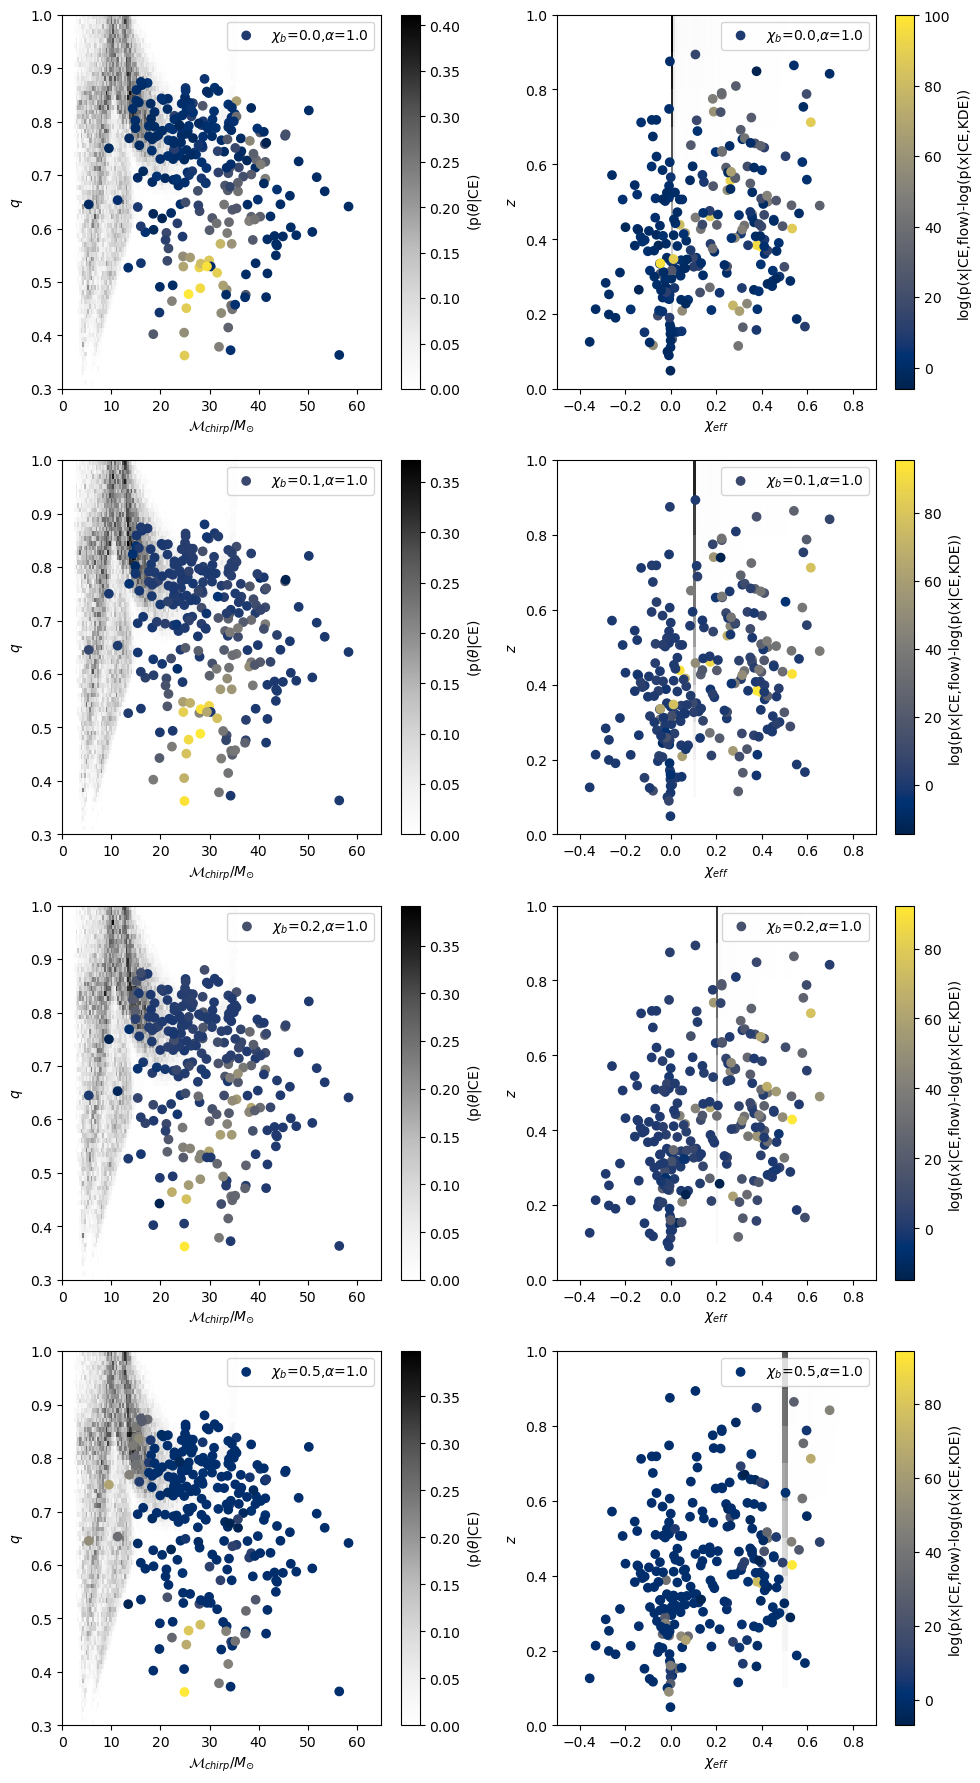

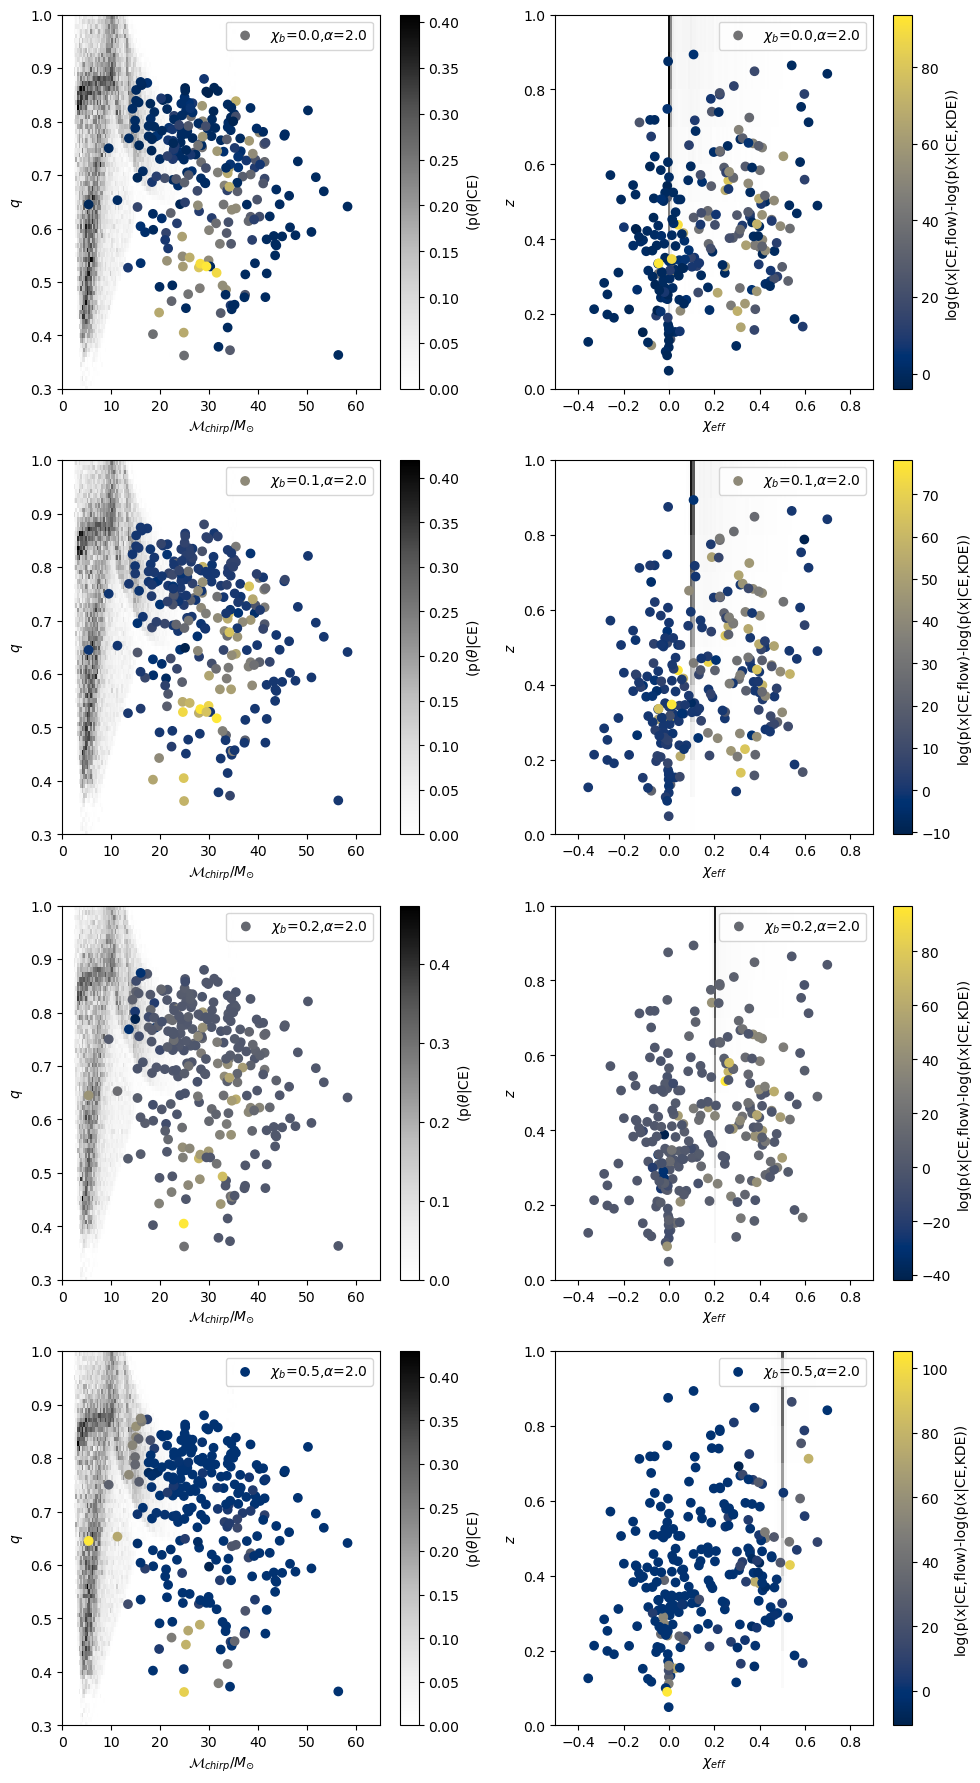

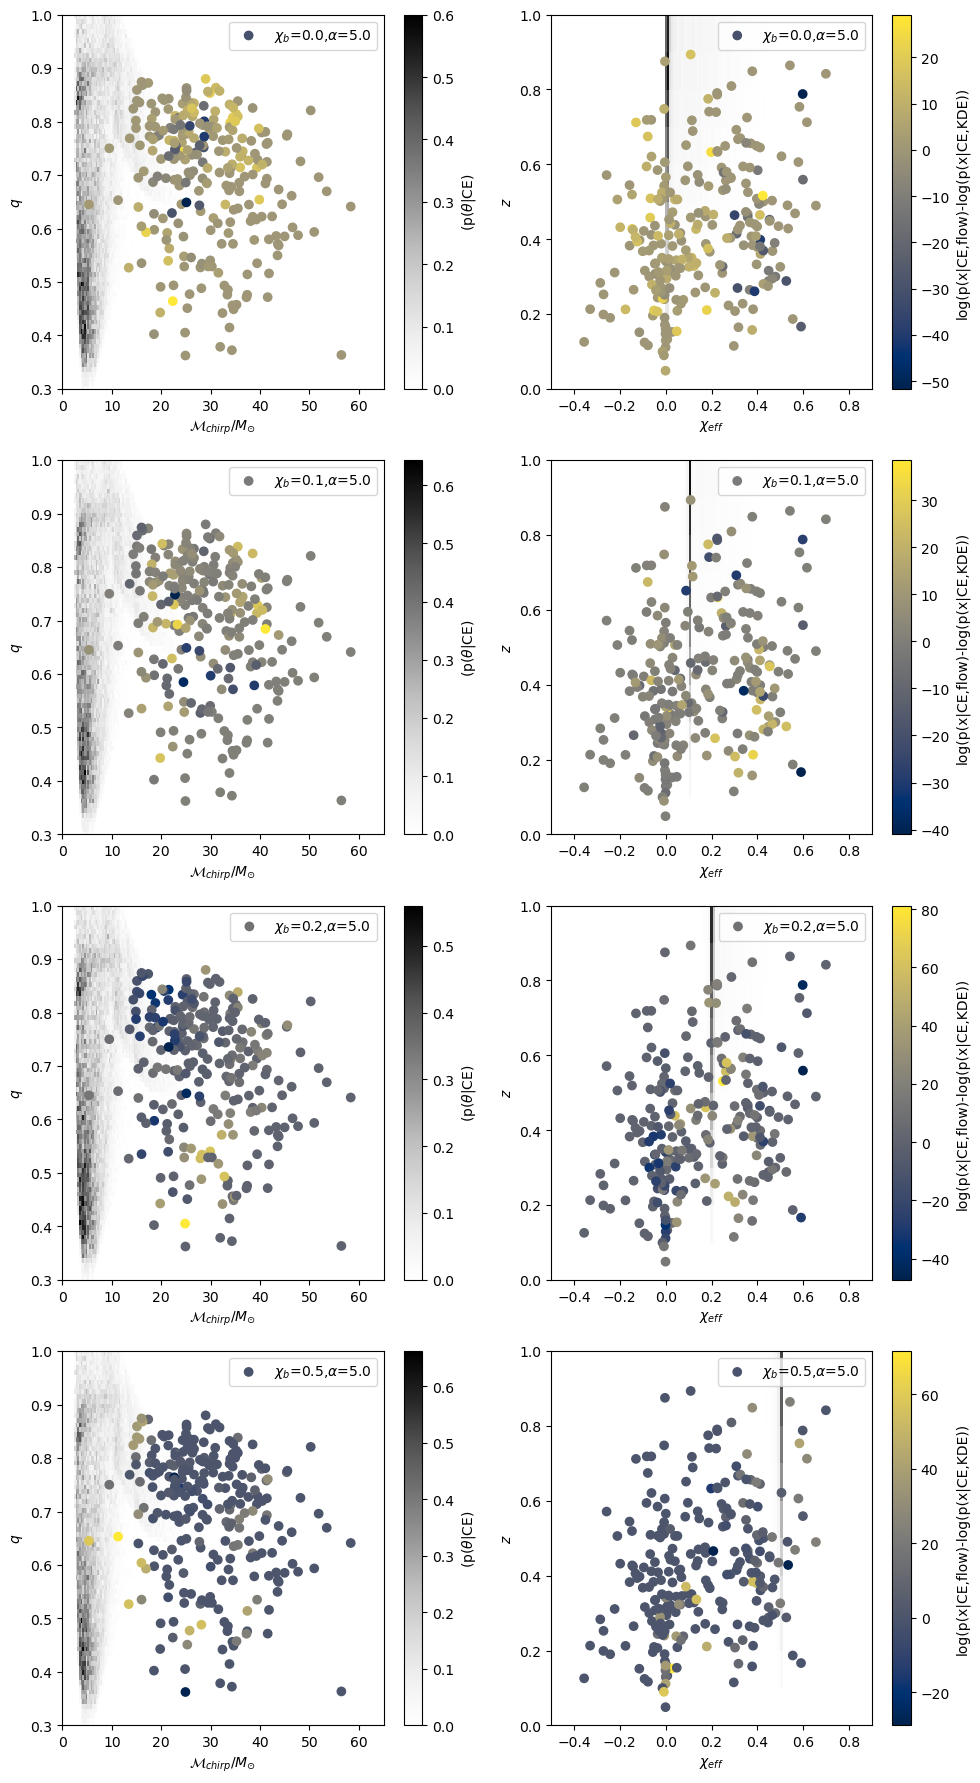

In [165]:
plt.rcParams["figure.figsize"] = (10,18)
for alphaid in range(5):
    fig, ax = plt.subplots(4,2)
    for chibid in range(4):

        p_theta = ax[chibid,0].hist2d(popsynth_outputs[chibid,alphaid]['mchirp'],popsynth_outputs[chibid,alphaid]['q'], bins=100,\
            weights=popsynth_outputs[chibid,alphaid]['weight'], cmap='Greys', density=True)
        ax[chibid,0].scatter(obsdata[:,:,0],obsdata[:,:,1], c=llh_ratio_kdeflow_kde[chibid,alphaid], cmap=cm.cividis, label=fr'$\chi_b$={chi_b[chibid]},$\alpha$={alpha[alphaid]}')
        ax[chibid,0].set_xlabel(r'$\mathcal{M}_{chirp} /M_{\odot}$')
        ax[chibid,0].set_ylabel(r'$q$')
        ax[chibid,0].set_ylim(0.3,1)
        ax[chibid,0].set_xlim(0,65)
        ax[chibid,0].legend()
        ax[chibid,1].hist2d(popsynth_outputs[chibid,alphaid]['chieff'],popsynth_outputs[chibid,alphaid]['z'], bins=100,\
            weights=popsynth_outputs[chibid,alphaid]['weight'], cmap='Greys', density=True)
        sp=ax[chibid,1].scatter(obsdata[:,:,2],obsdata[:,:,3], c=llh_ratio_kdeflow_kde[chibid,alphaid], cmap=cm.cividis, label=fr'$\chi_b$={chi_b[chibid]},$\alpha$={alpha[alphaid]}')
        ax[chibid,1].set_ylim(0.,1)
        ax[chibid,1].set_xlim(-0.5,0.9)
        ax[chibid,1].set_xlabel(r'$\chi_{eff}$')
        ax[chibid,1].set_ylabel(r'$z$')
        ax[chibid,1].legend()
        #fig.colorbar(ax=ax[chibid,1], label='log(ptheta_flow)-log(ptheta_kde)')
        cbar = fig.colorbar(sp,ax=ax[chibid,1])
        cbar.set_label(fr'log(p(x|{channels[0]},flow)-log(p(x|{channels[0]},KDE))')
        cbar = fig.colorbar(p_theta[3],ax=ax[chibid,0])
        cbar.set_label(fr'(p($\theta$|{channels[0]})')

    fig.tight_layout(pad=1.3)
    fig.savefig(f'{channels[0]}_llhratio_simevents_2_chi00_alpha{alphaid}_kdeflow_kde.pdf')